In [1]:
import datetime
import random
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from PIL import Image

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.6.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetB_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetB_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
RCP85_A_Compo_nc.snap_TMQ

<xarray.DataArray 'snap_TMQ' (snapshot: 6331, y: 80, x: 80)>
[40518400 values with dtype=float32]
Coordinates:
  * x        (x) float64 -11.85 -11.55 -11.25 -10.95 ... 10.95 11.25 11.55 11.85
  * y        (y) float64 -11.85 -11.55 -11.25 -10.95 ... 10.95 11.25 11.55 11.85
Dimensions without coordinates: snapshot

In [20]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [21]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [22]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
#    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP": SLP, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [23]:
# Find 850hPa Windspeed From Compo File
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [24]:
# Find Precip Rate From Compo File
def Precip_Rate(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [25]:
# Find Precipitable Water From Compo File
def Precip_Water(Compo_nc, Compo_Index):
    Precipitable_Water = numpy.array(Compo_nc.snap_TMQ[int(Compo_Index)])
    return (Precipitable_Water)

In [26]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((6,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
# Count Number of Data Points With Windspeed Above 13,18,25,33m/s
        Snap_Sort = numpy.sort(Snap_850.ravel())
        Count_13 = len(Snap_Sort[Snap_Sort >= 13])
        Count_18 = len(Snap_Sort[Snap_Sort >= 18])
        Count_25 = len(Snap_Sort[Snap_Sort >= 25])
        Count_33 = len(Snap_Sort[Snap_Sort >= 33])
        Wind_Field_Info[2][k] = Count_13
        Wind_Field_Info[3][k] = Count_18
        Wind_Field_Info[4][k] = Count_25
        Wind_Field_Info[5][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    DF_Storm_Compo["13m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["18m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["25m/s"] = Wind_Field_Info[4]
    DF_Storm_Compo["33m/s"] = Wind_Field_Info[5]
    return (DF_Storm_Compo, Time_List)

In [27]:
# Find Max Precip and Total Precip Over Area
def Precip_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
#
# Create Array to Store Data
    Precip_Field_Info = numpy.zeros((7,len(Compo_Index)))
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find Precip Snap From Compo_nc
        Snap_Precip = Precip_Rate(Compo_nc, Compo_Index[k])
# Find Maximum Precip Rate
        Max_Precip = numpy.max(Snap_Precip)
        Precip_Field_Info[0][k] = Max_Precip
# Find Total Areal Precip
        Snap_Sort = numpy.sort(Snap_Precip.ravel())
        Areal_Precip_Total = numpy.sum(Snap_Sort)
        Precip_Field_Info[1][k] = Areal_Precip_Total
# Count Number of Data Points With Precip Rate Above 1, 5, 10mm/hr
        Count_1 = len(Snap_Sort[Snap_Sort >= 1])
        Count_5 = len(Snap_Sort[Snap_Sort >= 5])
        Count_10 = len(Snap_Sort[Snap_Sort >= 10])
        Precip_Field_Info[2][k] = Count_1
        Precip_Field_Info[3][k] = Count_5
        Precip_Field_Info[4][k] = Count_10
#
# Find Precipitable Water Snap From Compo_nc
        Snap_Precip_Water = Precip_Water(Compo_nc, Compo_Index[k])
# Find Maximum Precipitable Water
        Max_Precip_Water = numpy.max(Snap_Precip_Water)
        Precip_Field_Info[5][k] = Max_Precip_Water
# Find Areal Precipitable Water Total
        Precip_Water_Total = numpy.sum(Snap_Precip_Water.ravel())
        Precip_Field_Info[6][k] = Precip_Water_Total
# 
# Add Precip Field Info Into DF Storm Compo
    DF_Storm_Compo["Max Precip Rate"] = Precip_Field_Info[0]
    DF_Storm_Compo["Total Areal Precip"] = Precip_Field_Info[1]
    DF_Storm_Compo["1mm/hr"] = Precip_Field_Info[2]
    DF_Storm_Compo["5mm/hr"] = Precip_Field_Info[3]
    DF_Storm_Compo["10mm/hr"] = Precip_Field_Info[4]
    DF_Storm_Compo["Max Precip Water"] = Precip_Field_Info[5]
    DF_Storm_Compo["Total Precip Water"] = Precip_Field_Info[6]
    return (DF_Storm_Compo, Time_List)

In [28]:
# Calculate Grid Size Between Each Datapoint
# def Find_Grid_Size()

In [29]:
# Plot Wind Field Information
def SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Wind Field Information
    DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#    Colour_3 = 'darkorange'
#
# Axis For Max Windspeed
    Ax1 = Fig.add_subplot(2,2,1)
#    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["850hPa Winds"][k], c=Colour_1, marker=Shape, s=38)
#        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"][k], c=Colour_3, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["850hPa Winds"], color=Colour_1, linewidth=1.2, \
    label='850hPa Windspeed')
#    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"], color=Colour_3, linewidth=1.2, \
#    label='Surface Windspeed')
#    pyplot.legend(loc=1)
#
# Axis For Wind Field Size
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["SLP"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, DF_Storm_Compo_Wind_Field["SLP"], color=Colour_2, linewidth=1.2, label='Sea Level Pressure')
#
# Formatting
    Ax1, Ax2 = SLP_Windspeed_Axis(DF_Storm_Compo_Wind_Field["SLP"], Ax1, Ax2)
    Ax2 = Time_Axis(Time_List, Ax2)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max 850hPa Windspeed (m/s)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Sea Level Pressure (hPa)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Min SLP & Max 850hPa Windspeed")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7280000], c='black', linestyle='--', linewidth=0.8)

In [30]:
# Plot Wind Field Information
def Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Wind Field Information
    DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'deepskyblue'
    Colour_2 = 'lightseagreen'
    Colour_3 = 'limegreen'
    Colour_4 = 'gold'
#
# Axis For Wind Field Size
    Ax1 = Fig.add_subplot(2,2,3)
#    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo["13m/s"][k], c=Colour_1, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["18m/s"][k], c=Colour_2, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["25m/s"][k], c=Colour_3, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["33m/s"][k], c=Colour_4, marker=Shape, s=28)
    Ax1.plot(Time_List, DF_Storm_Compo["13m/s"], color=Colour_1, linewidth=1.2, label='# Gridpoints >= 13m/s')
    Ax1.plot(Time_List, DF_Storm_Compo["18m/s"], color=Colour_2, linewidth=1.2, label='# Gridpoints >= 18m/s')
    Ax1.plot(Time_List, DF_Storm_Compo["25m/s"], color=Colour_3, linewidth=1.2, label='# Gridpoints >= 25m/s')
    Ax1.plot(Time_List, DF_Storm_Compo["33m/s"], color=Colour_4, linewidth=1.2, label='# Gridpoints >= 33m/s')
    pyplot.legend(loc=2, fontsize=12)
#
# Formatting
    Ax1 = Wind_Field_Axis(DF_Storm_Compo["13m/s"], Ax1)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor='darkgreen')
    Title = str(Code + ' ' + Storm_Name + " -- 850hPa Wind Field")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax1.plot([Time, Time], [0,7280000], c='black', linestyle='--', linewidth=0.8)

In [31]:
# Plot Precip Field Information
def Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Precip Field Information
    DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#
# Axis For Max Precip Rate
    Ax1 = Fig.add_subplot(2,2,2)
#    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Max Precip Rate"][k], c=Colour_1, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Precip_Field["Max Precip Rate"], color=Colour_1, linewidth=1.2, \
    label='Max Precip Rate')
#
# Axis For Total Areal Precip
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Total Areal Precip"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, DF_Storm_Compo_Precip_Field["Total Areal Precip"], color=Colour_2, linewidth=1.2, \
    label='Total Areal Precip')
#
# Formatting
    Ax1, Ax2 = Precip_Rate_Axis(DF_Storm_Compo_Precip_Field["Max Precip Rate"], Ax1, Ax2)
    Ax2 = Time_Axis(Time_List, Ax2)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max Precip Rate (mm/hr)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Total Areal Precip (mm/hr #gridpoints)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Precip Rate")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7280000], c='black', linestyle='--', linewidth=0.8)

In [32]:
# Plot Precipitable Water Information
def Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Precip Field Information
    DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#
# Axis For Max Precipitable Water
    Ax1 = Fig.add_subplot(2,2,4)
#    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Max Precip Water"][k], c=Colour_1, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Precip_Field["Max Precip Water"], color=Colour_1, linewidth=1.2, \
    label='Max Precipitable Water')
#
# Axis For Total Precipitable Water
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Total Precip Water"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, DF_Storm_Compo_Precip_Field["Total Precip Water"], color=Colour_2, linewidth=1.2, \
    label='Precipitable Water Total')
#
# Formatting
    Ax1, Ax2 = Precip_Water_Axis(DF_Storm_Compo_Precip_Field["Max Precip Water"], Ax1, Ax2)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max Precipitable Water (mm)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Total Precipitable Water (mm #gridpoints)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Precipitable Water")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7280000], c='black', linestyle='--', linewidth=0.8)

In [33]:
# Plot Wind Field Information
def Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Precip Field Information
    DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'dodgerblue'
    Colour_2 = 'limegreen'
    Colour_3 = 'greenyellow'
#
# Axis For Wind Field Size
    Ax1 = Fig.add_subplot(2,2,4)
#    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo["1mm/hr"][k], c=Colour_1, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["5mm/hr"][k], c=Colour_2, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["10mm/hr"][k], c=Colour_3, marker=Shape, s=28)
    Ax1.plot(Time_List, DF_Storm_Compo["1mm/hr"], color=Colour_1, linewidth=1.2, label='# Gridpoints >= 1mm/hr')
    Ax1.plot(Time_List, DF_Storm_Compo["5mm/hr"], color=Colour_2, linewidth=1.2, label='# Gridpoints >= 5mm/hr')
    Ax1.plot(Time_List, DF_Storm_Compo["10mm/hr"], color=Colour_3, linewidth=1.2, label='# Gridpoints >= 10mm/hr')
    pyplot.legend(loc=2)
#
# Formatting
    Ax1 = Wind_Field_Axis(DF_Storm_Compo["1mm/hr"], Ax1)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor='darkgreen')
    Title = str(Code + ' ' + Storm_Name + " -- Precip Field")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax1.plot([Time, Time], [0,7280000], c='black', linestyle='--', linewidth=0.8)

In [34]:
def Time_Axis(Time, Ax2):
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    if len(Time) <= 50:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    elif len(Time) <= 75:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='4D')
    Ax2.set_xlabel('Time (Z)', fontsize=12)
    Ax2.set_xticks(x_Axis)
    Ax2.set_xlim(x_Min,x_Max)
    return (Ax2)

In [35]:
def SLP_Windspeed_Axis(SLP, Ax1, Ax2):
    y_Min = int(numpy.min(SLP) / 10) * 10
    if y_Min > 940:
        Ax2.set_yticks(Create_Bins(940,1020,10))
        Ax2.set_ylim(940,1020)
        Ax1.set_yticks(Create_Bins(0,80,10))
        Ax1.set_ylim(0,80)
    else:
        Ax2.set_yticks(Create_Bins(y_Min,1020,10))
        Ax2.set_ylim(y_Min,1020)
        y_Max = 1020-y_Min
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
    return (Ax1, Ax2)

In [36]:
def Wind_Field_Axis(Count_13, Ax1):
    y_Max = int(numpy.max(Count_13) / 250 + 1) * 250
    if y_Max <= 1000:
        Ax1.set_yticks(Create_Bins(0,1000,100))
        Ax1.set_ylim(0,1000)
    elif y_Max <= 3000:
        Ax1.set_yticks(Create_Bins(0,y_Max,250))
        Ax1.set_ylim(0,y_Max)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,500))
        Ax1.set_ylim(0,y_Max)
    return (Ax1)

In [37]:
def Precip_Rate_Axis(Max_Precip, Ax1, Ax2):
    y_Max = int(numpy.max(Max_Precip) / 10 + 1) * 10
    if y_Max < 50:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,50)
        Ax2.set_yticks(Create_Bins(0,2500,500))
        Ax2.set_ylim(0,2500)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
        Ax2.set_yticks(Create_Bins(0,y_Max*50,500))
        Ax2.set_ylim(0,y_Max*50)
    return (Ax1, Ax2)

In [38]:
def Precip_Water_Axis(Max_Precip, Ax1, Ax2):
    y_Max = int(numpy.max(Max_Precip) / 10 + 1) * 10
    if y_Max < 50:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,50)
        Ax2.set_yticks(Create_Bins(0,250000,50000))
        Ax2.set_ylim(0,250000)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
        Ax2.set_yticks(Create_Bins(0,y_Max*5000,50000))
        Ax2.set_ylim(0,y_Max*5000)
    return (Ax1, Ax2)

In [39]:
def Precip_Field_Axis(Count, Ax1):
    y_Max = int(numpy.max(Count) / 250 + 1) * 250
    if y_Max <= 1000:
        Ax1.set_yticks(Create_Bins(0,1000,100))
        Ax1.set_ylim(0,1000)
    elif y_Max <= 3000:
        Ax1.set_yticks(Create_Bins(0,y_Max,250))
        Ax1.set_ylim(0,y_Max)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,500))
        Ax1.set_ylim(0,y_Max)
    return (Ax1)

In [40]:
# Plot Marker
def Plot_Marker(Storm_Phase):
    if Storm_Phase == "Tropical":
        Shape = 'o'
    elif Storm_Phase == "Transition":
        Shape = 's'
    else:
        Shape = '^'
    return (Shape)

In [41]:
# Define Colours and Bounds
Windspeed_Colours = ['white', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
Precip_Rate_Colours = ['white', 'cyan', 'deepskyblue', 'dodgerblue', 'lightseagreen', 'limegreen', 'greenyellow', \
'gold', 'darkorange', 'red', 'darkviolet']
Precip_Rate_Bounds = numpy.array([0.1,0.5,1,2,5,10,20,30,50,70])
Precip_Water_Colours = ['white', 'aquamarine', 'springgreen', 'aqua', 'deepskyblue', 'dodgerblue', 'mediumblue', 'navy']
Precip_Water_Bounds = numpy.array([30,40,50,60,70,80,100])

In [42]:
# Create Function to Plot Contour Maps
def Contour_Map(Snap, x_Snap, y_Snap, Bounds, Colours, Storm_Name, Time_Label, Var, x_Label):
# Add Corrdinate Lines
    pyplot.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    pyplot.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Initial Indexes
    i_Init = 0
    j_Init = 0
    i_Fin = 80
    j_Fin = 80
# Plot Contour Map
    pyplot.contourf(x_Snap, y_Snap, Snap, levels=Bounds, colors=Colours, extend='both')
# Formatting
    x_Min = float(x_Snap[i_Init])
    x_Max = float(x_Snap[i_Fin-1])
    y_Min = float(y_Snap[j_Init])
    y_Max = float(y_Snap[j_Fin-1])
    pyplot.xlim(x_Min,x_Max)
    pyplot.ylim(y_Min,y_Max)
    if x_Label == True:
        pyplot.xlabel('Lon Diff From Storm Center', fontsize=12)
    pyplot.ylabel('Lat Diff From Storm Center', fontsize=12)
#    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Storm_Name + (' -- ') + Time_Label)
    pyplot.title(Title, fontsize=18)

In [43]:
# Plot Four Snap Plots
def Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Var, Unit, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Snap_0 = Snap_Var(Compo_nc, Indexes[0], Var)
    Contour_Map(Snap_0, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], Var, False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Snap_1 = Snap_Var(Compo_nc, Indexes[1], Var)
    Contour_Map(Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], Var, False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(Var, Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Cbar_Label = Var + ' (' + Unit + ')'
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label=Cbar_Label, shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Snap_2 = Snap_Var(Compo_nc, Indexes[2], Var)
    Contour_Map(Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], Var, False)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Snap_3 = Snap_Var(Compo_nc, Indexes[3], Var)
    Contour_Map(Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], Var, False)
#
# Save Fig
    if Savefig == True:
        if Var == "850hPa Windspeed":
            Figname = str(Code + '_' + Storm_Name + '_Wind_Snapshot.png')
        elif Var == "Precip Rate":
            Figname = str(Code + '_' + Storm_Name + '_Precip_Rate_Snapshot.png')
        elif Var == "Precipitable Water":
            Figname = str(Code + '_' + Storm_Name + '_Precip_Water_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [44]:
def Snap_Var(Compo_nc, Index, Var):
    if Var == "850hPa Windspeed":
        Snap = numpy.array(Windspeed_850hPa(Compo_nc, Index))
    elif Var == "Precip Rate":
        Snap = numpy.array(Precip_Rate(Compo_nc, Index))
    elif Var == "Precipitable Water":
        Snap = numpy.array(Precip_Water(Compo_nc, Index))
    return (Snap)

In [45]:
# Plot Four Windspeed Snap Plots
def Windspeed_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Windspeed_Snap_1 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[0]))
    Contour_Map(Windspeed_Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], "Windspeed", False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Windspeed_Snap_2 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[1]))
    Contour_Map(Windspeed_Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], "Windspeed", False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeeds", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeeds (m/s)', shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Windspeed_Snap_3 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[2]))
    Contour_Map(Windspeed_Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], "Windspeed", True)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Windspeed_Snap_4 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[3]))
    Contour_Map(Windspeed_Snap_4, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], "Windspeed", True)
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Wind_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [46]:
# Some Example Storms

In [47]:
# Find Wind Field Composite Data
Code = "TC191304"
Storm_Name = "Melody"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [3971,3987,3993,3999]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [48]:
#DF_Storm_Compo_Wind_Field

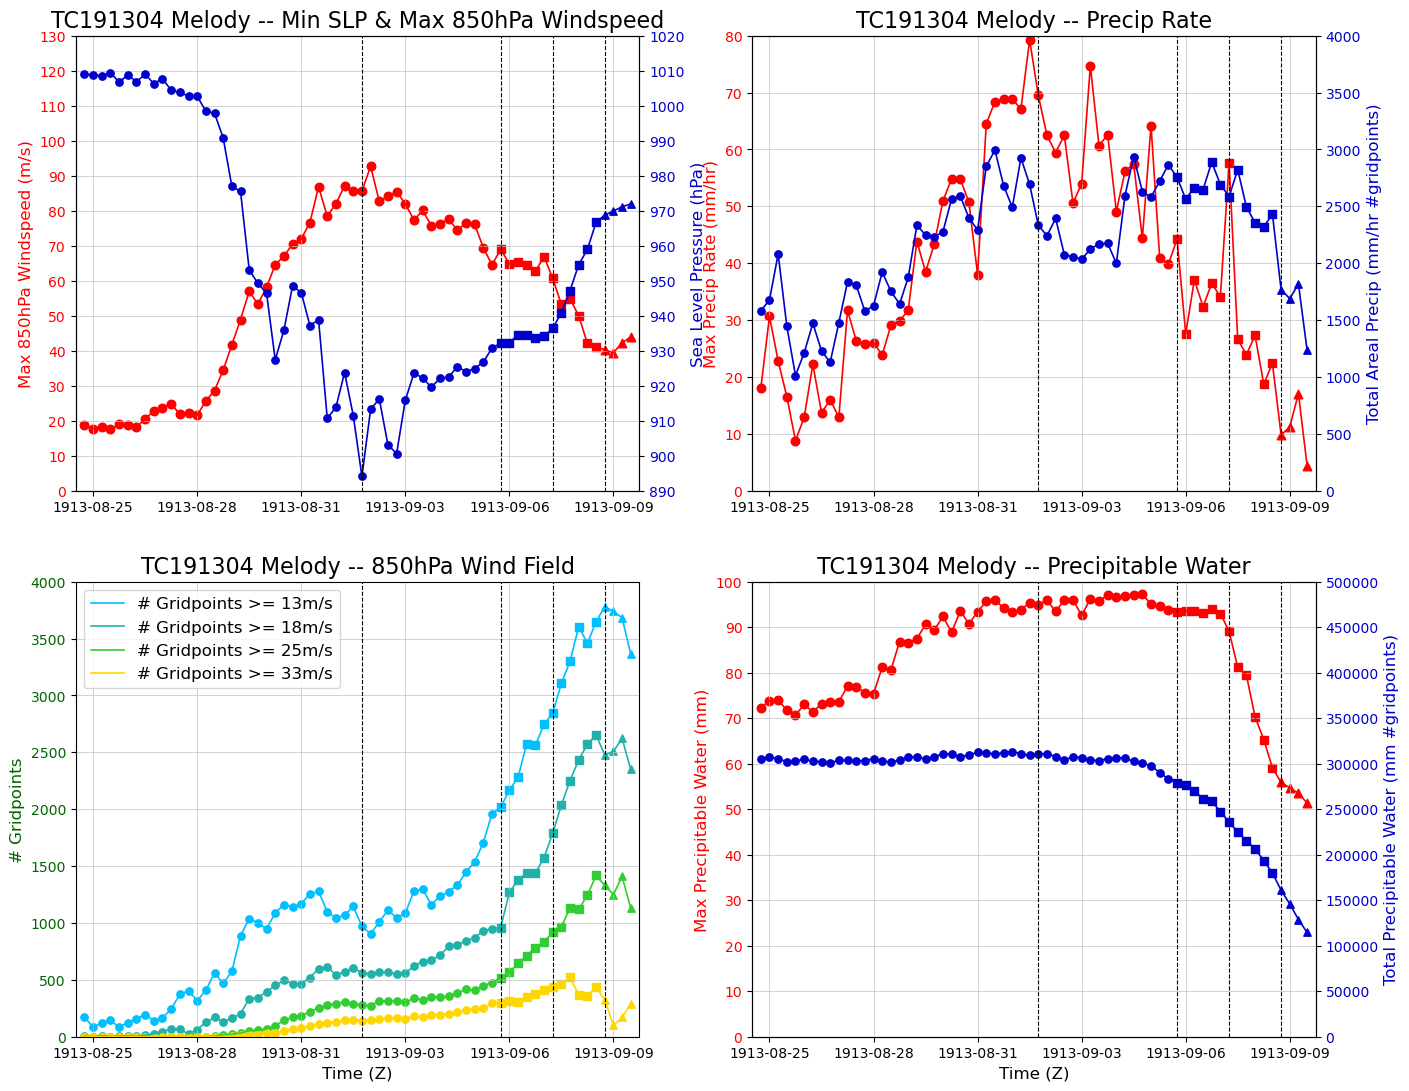

In [49]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

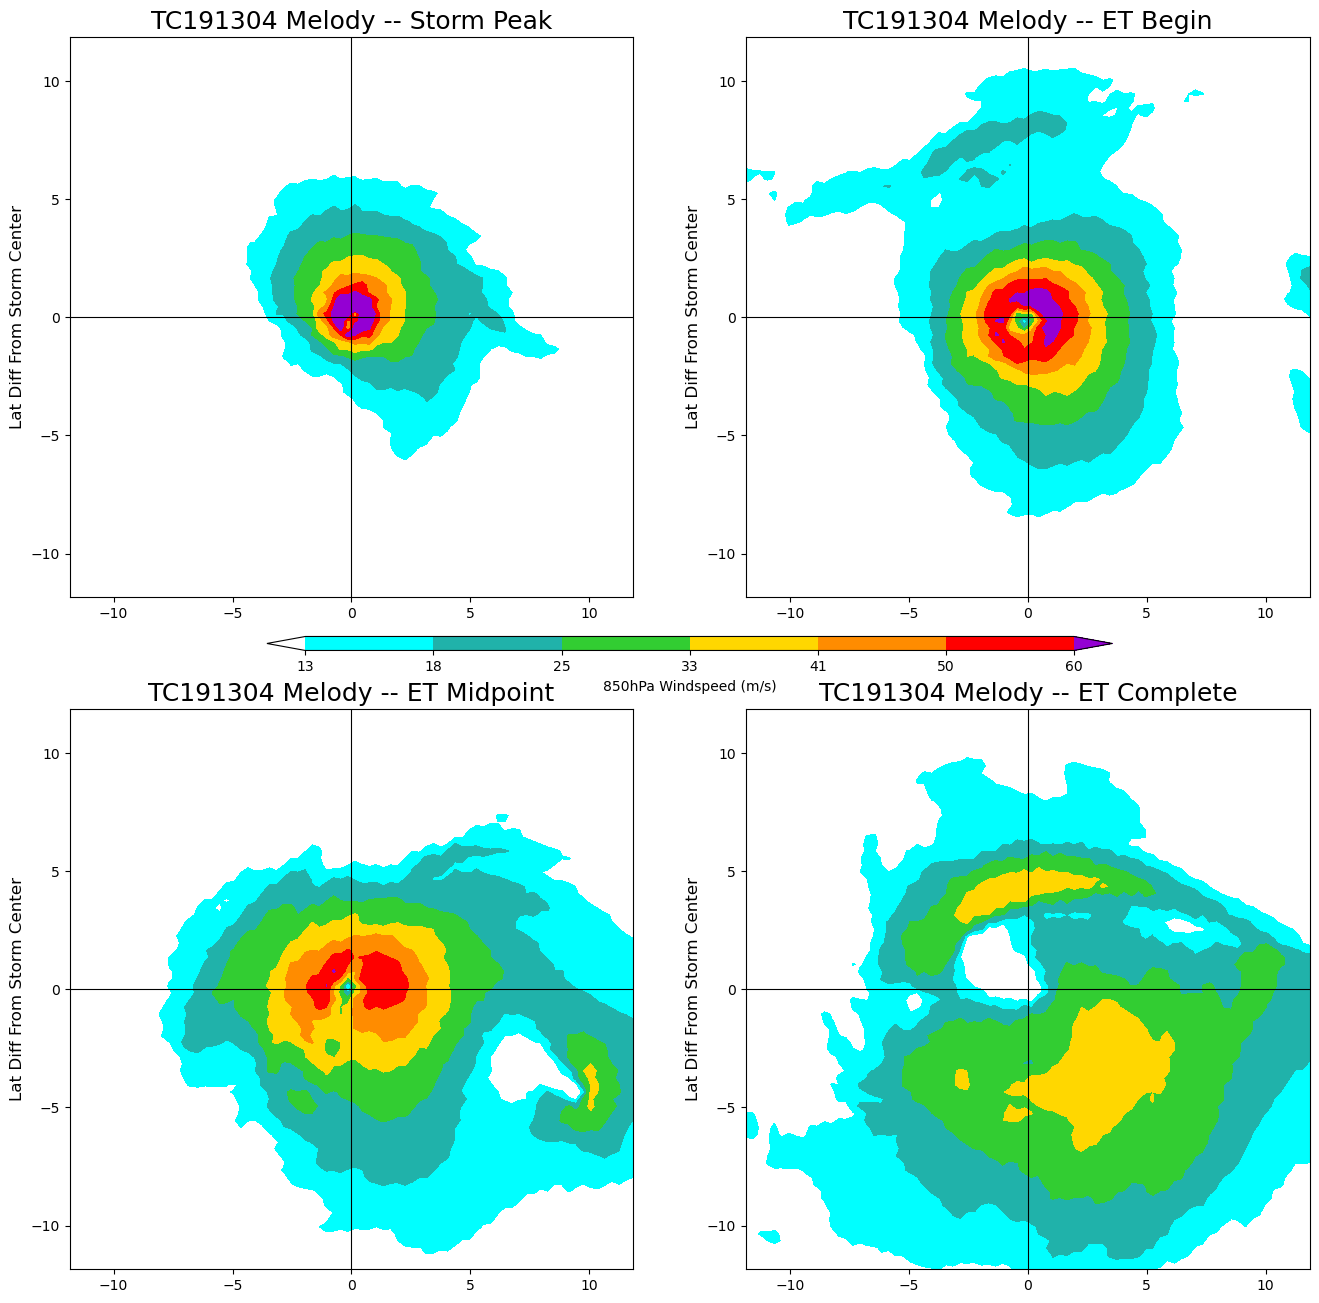

In [50]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

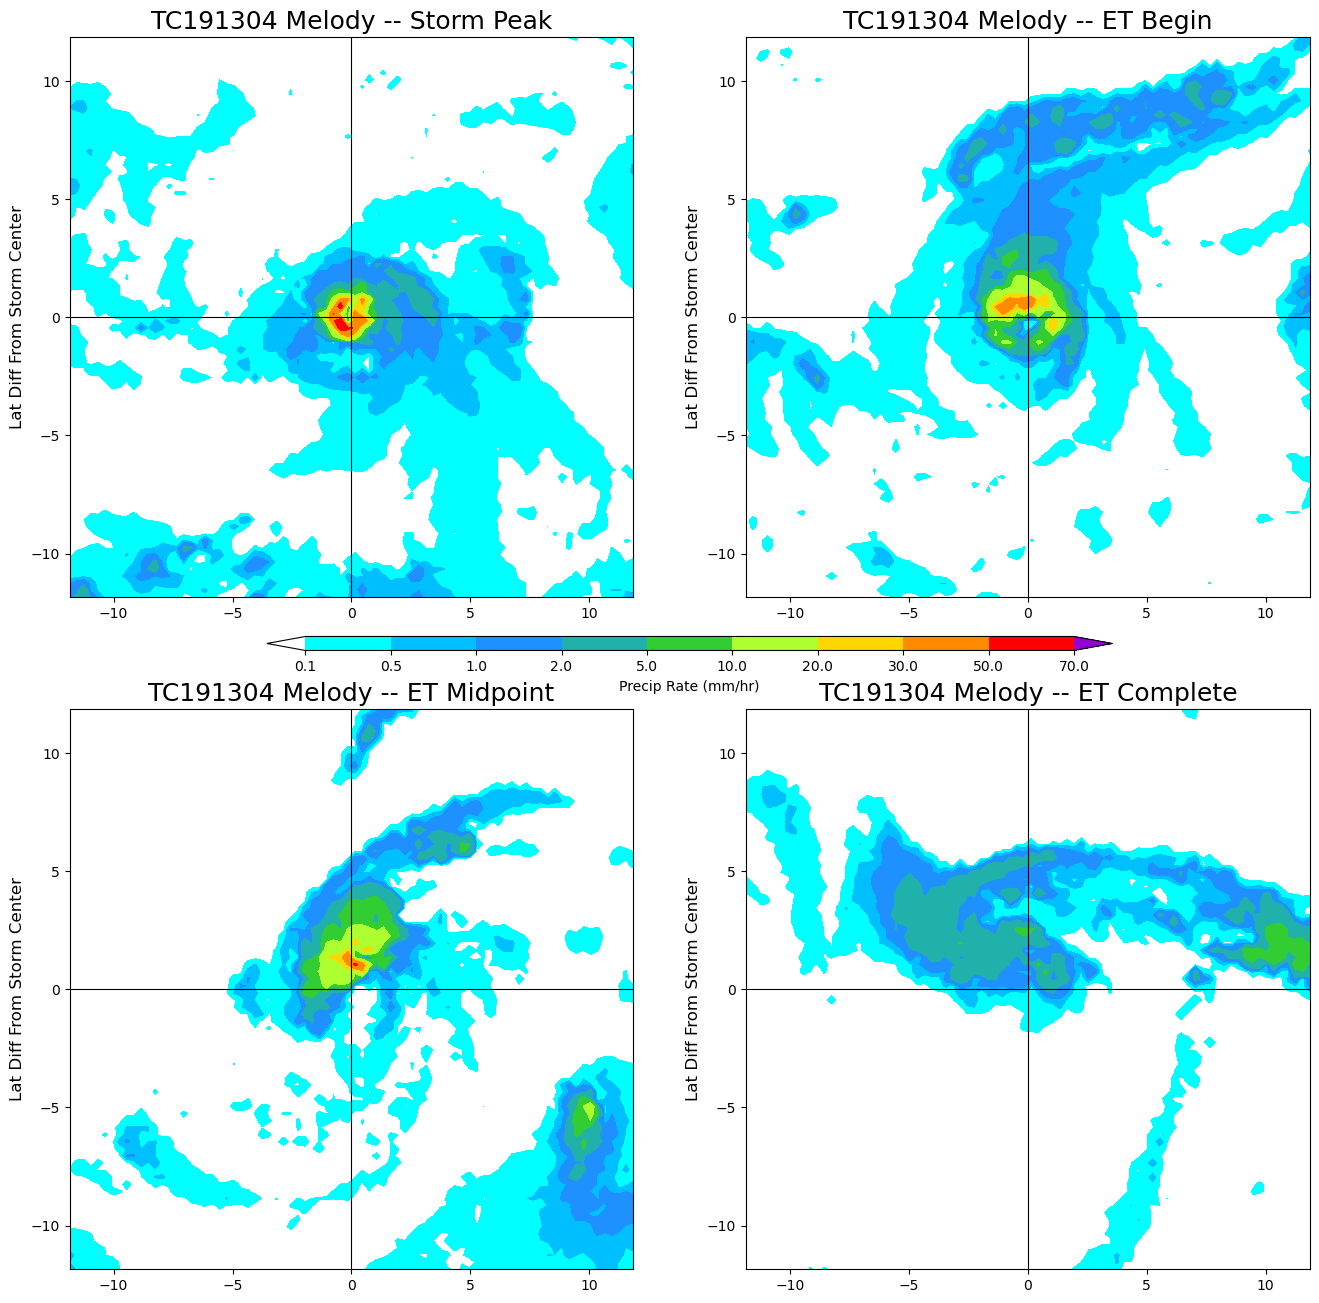

In [51]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

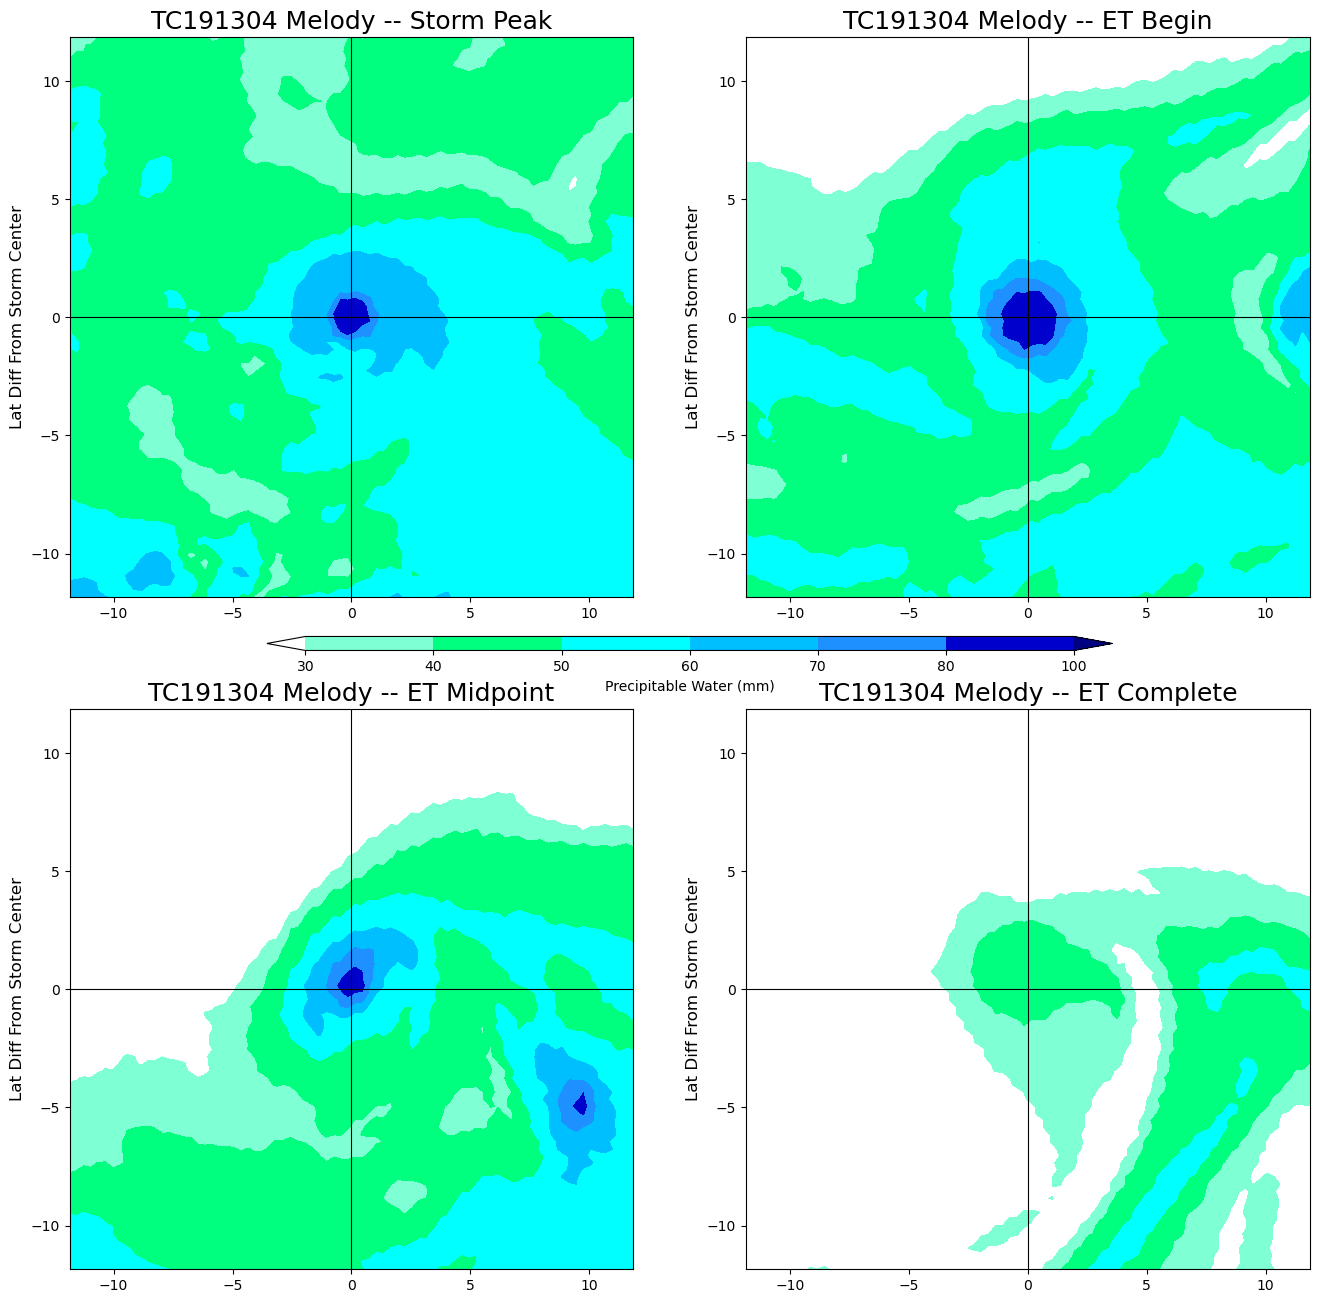

In [52]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [53]:
# Find Wind Field Composite Data
Code = "TC190003"
Storm_Name = "Colin"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [130,139,144,149]
Time_Labels = ["Initial Storm Peak", "ET Begin", "ET Midpt/Storm Peak", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [54]:
#DF_Storm_Compo_Wind_Field

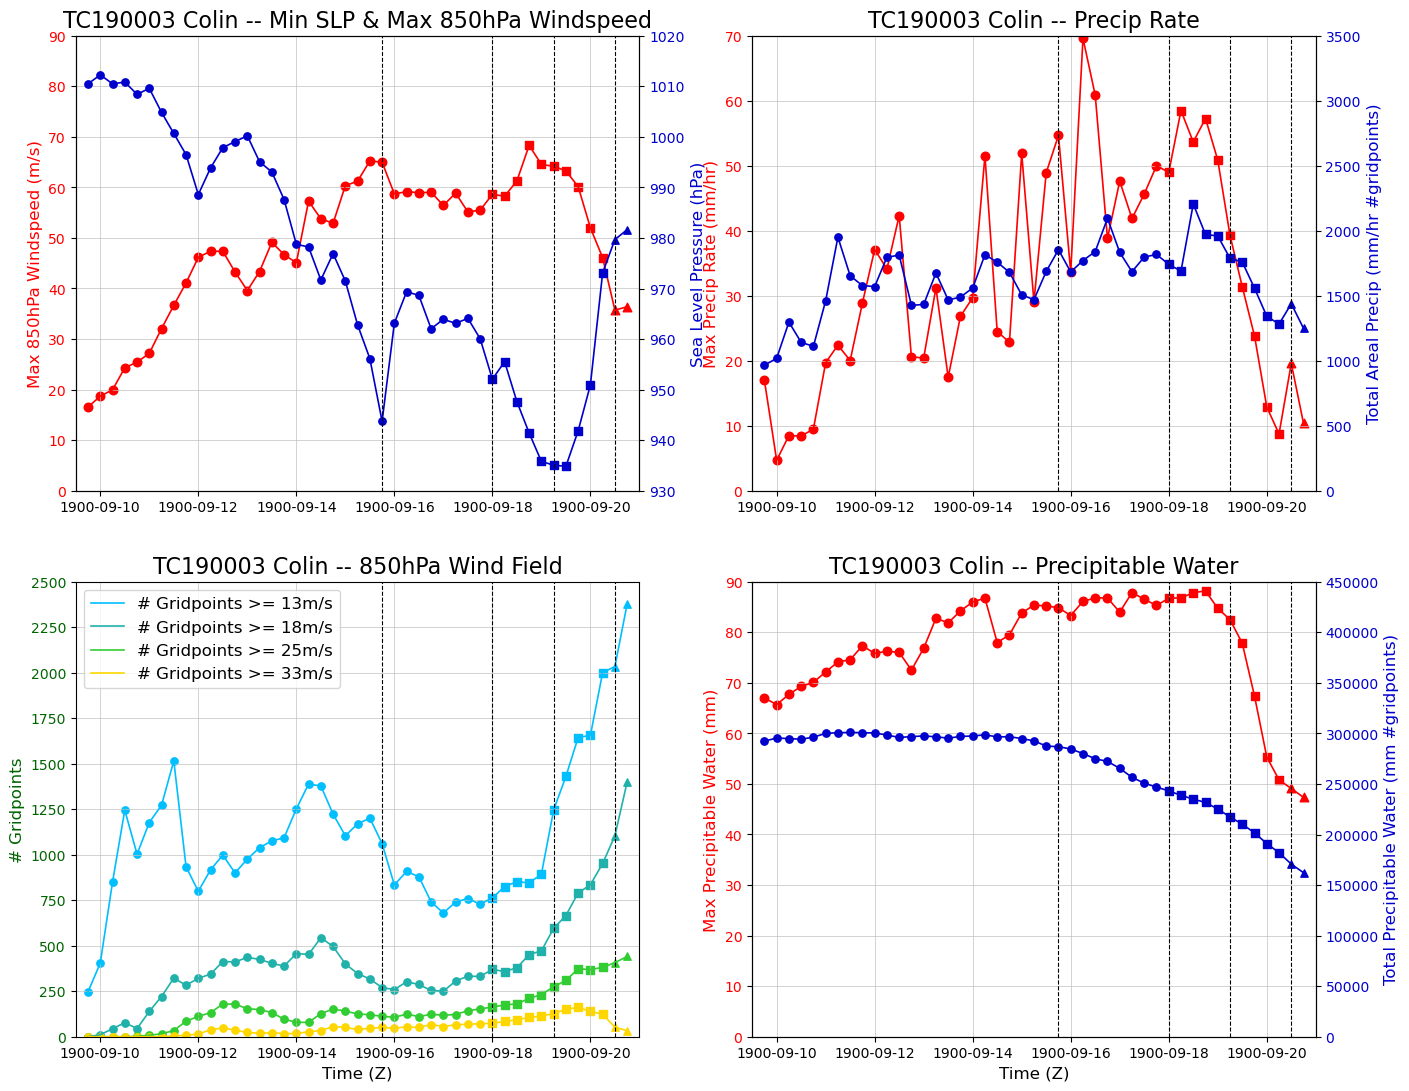

In [55]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

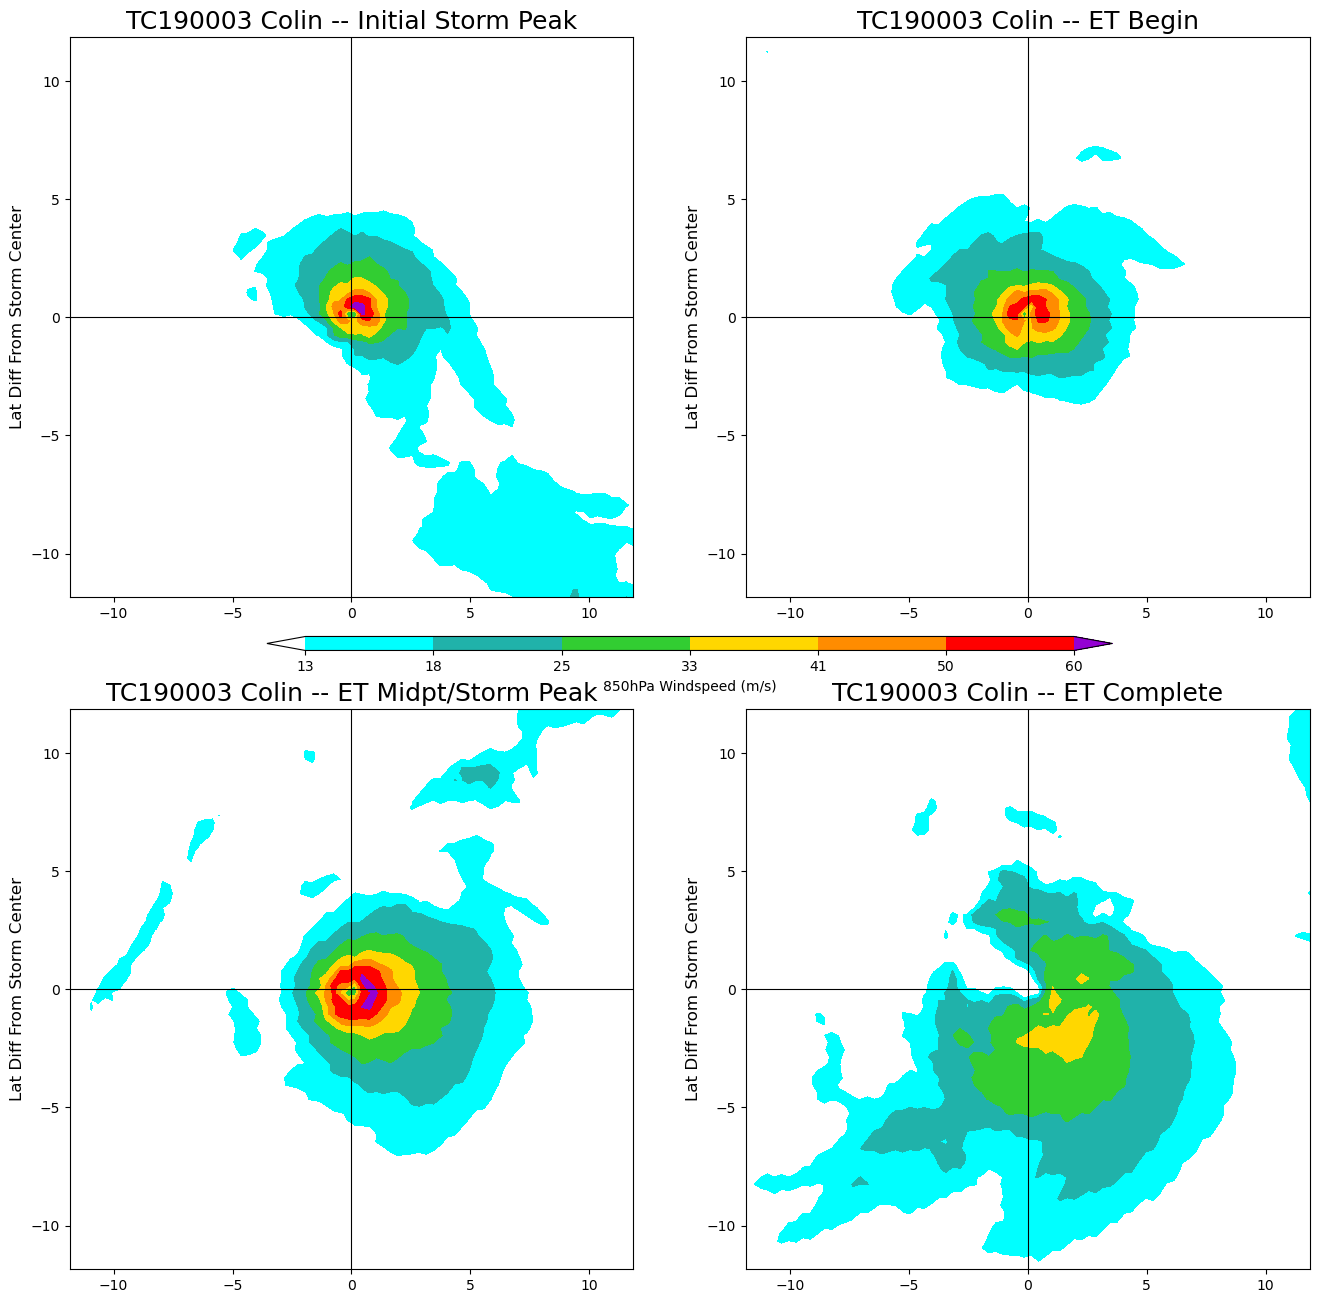

In [56]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

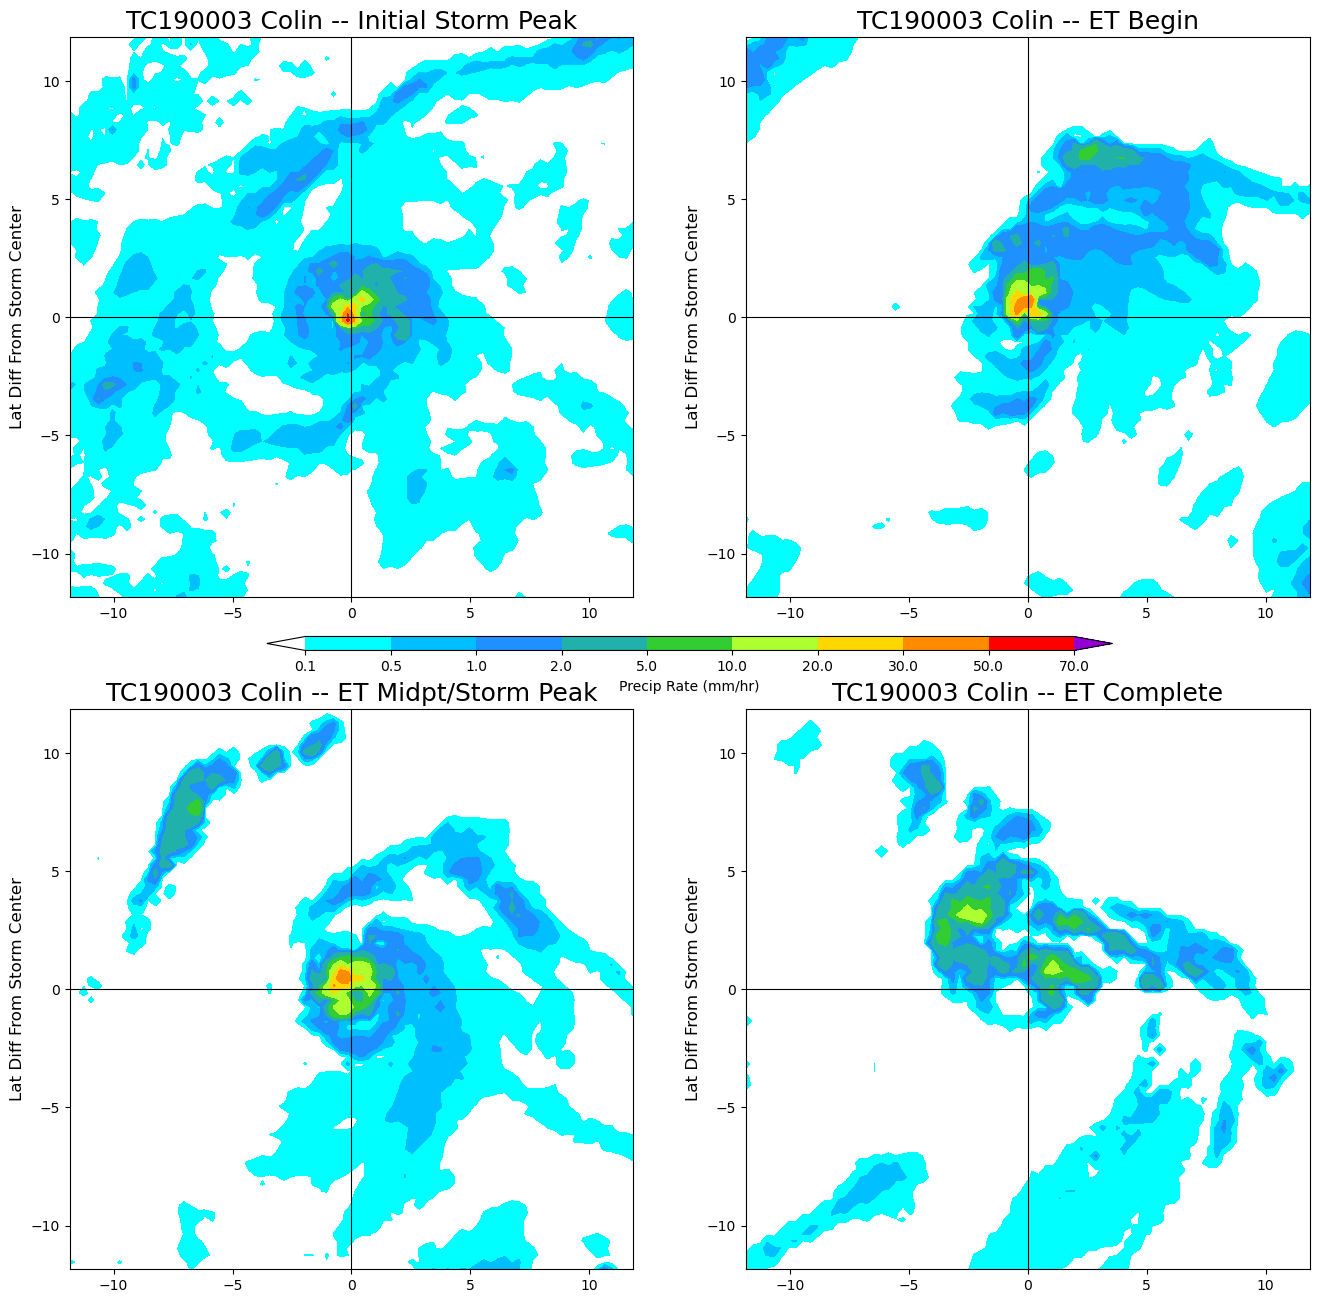

In [57]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

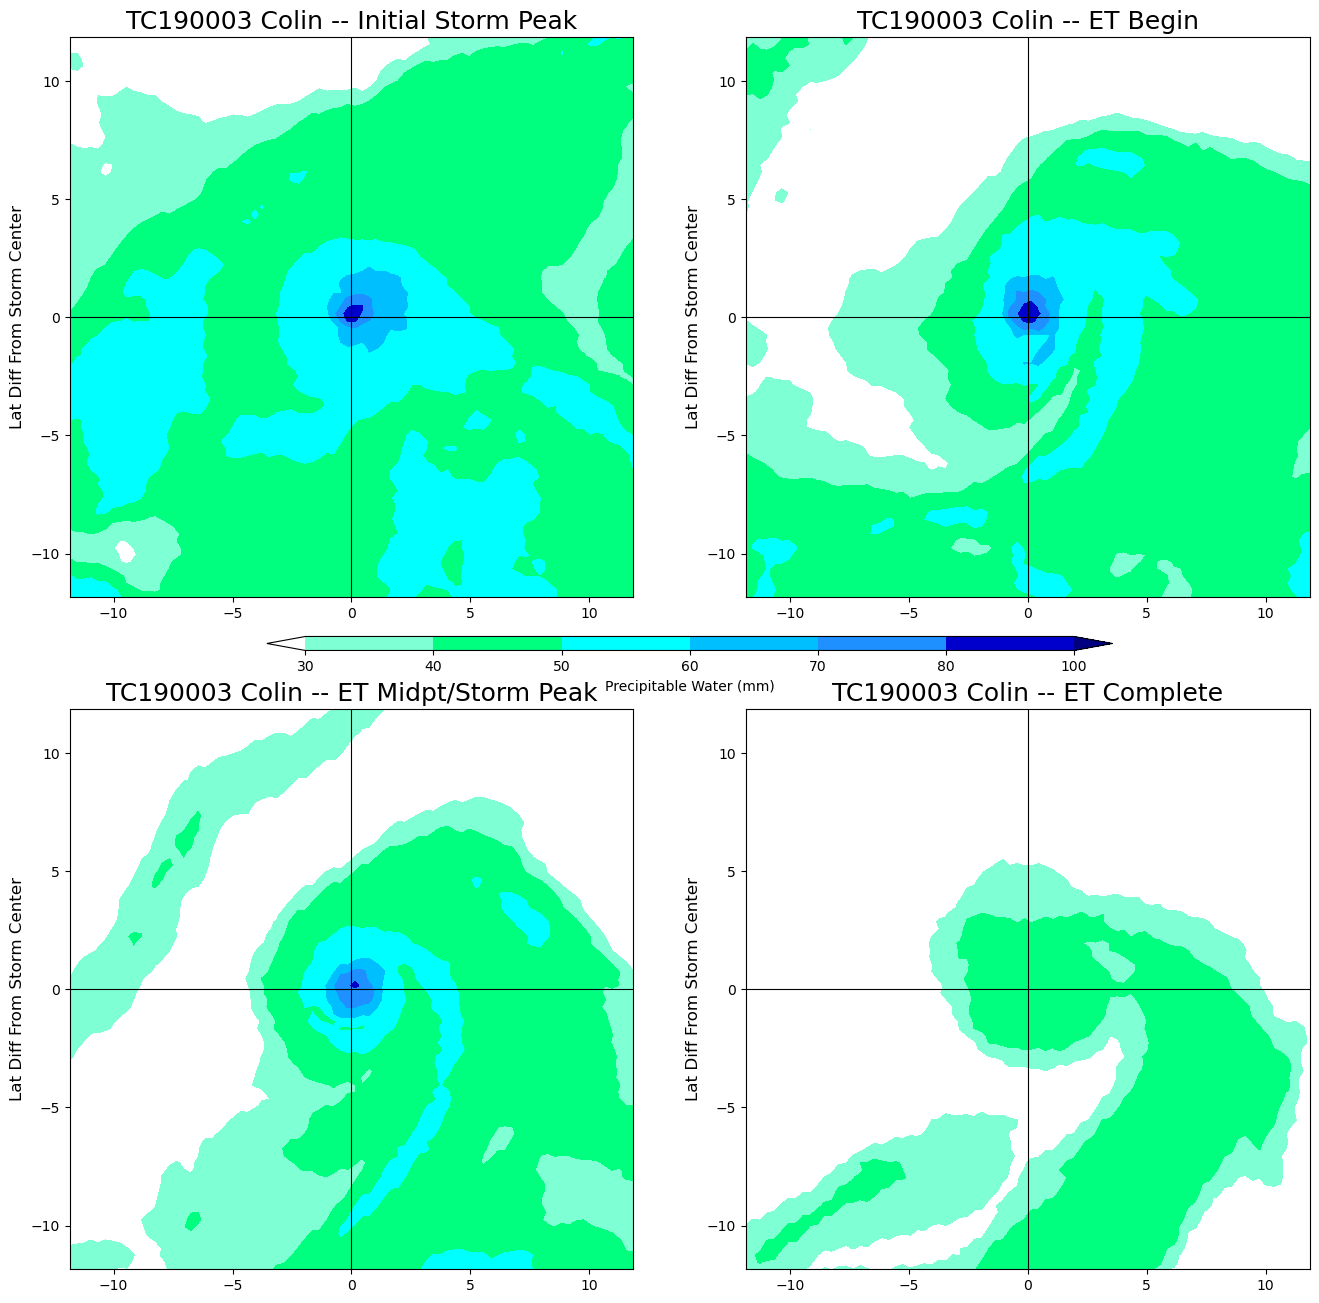

In [58]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [59]:
# Find Wind Field Composite Data
Code = "TC197807"
Storm_Name = "Maho"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_C_Compo_nc
Time_Indexes = [6131,6135,6141,6147]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [60]:
#DF_Storm_Compo_Wind_Field[30:]

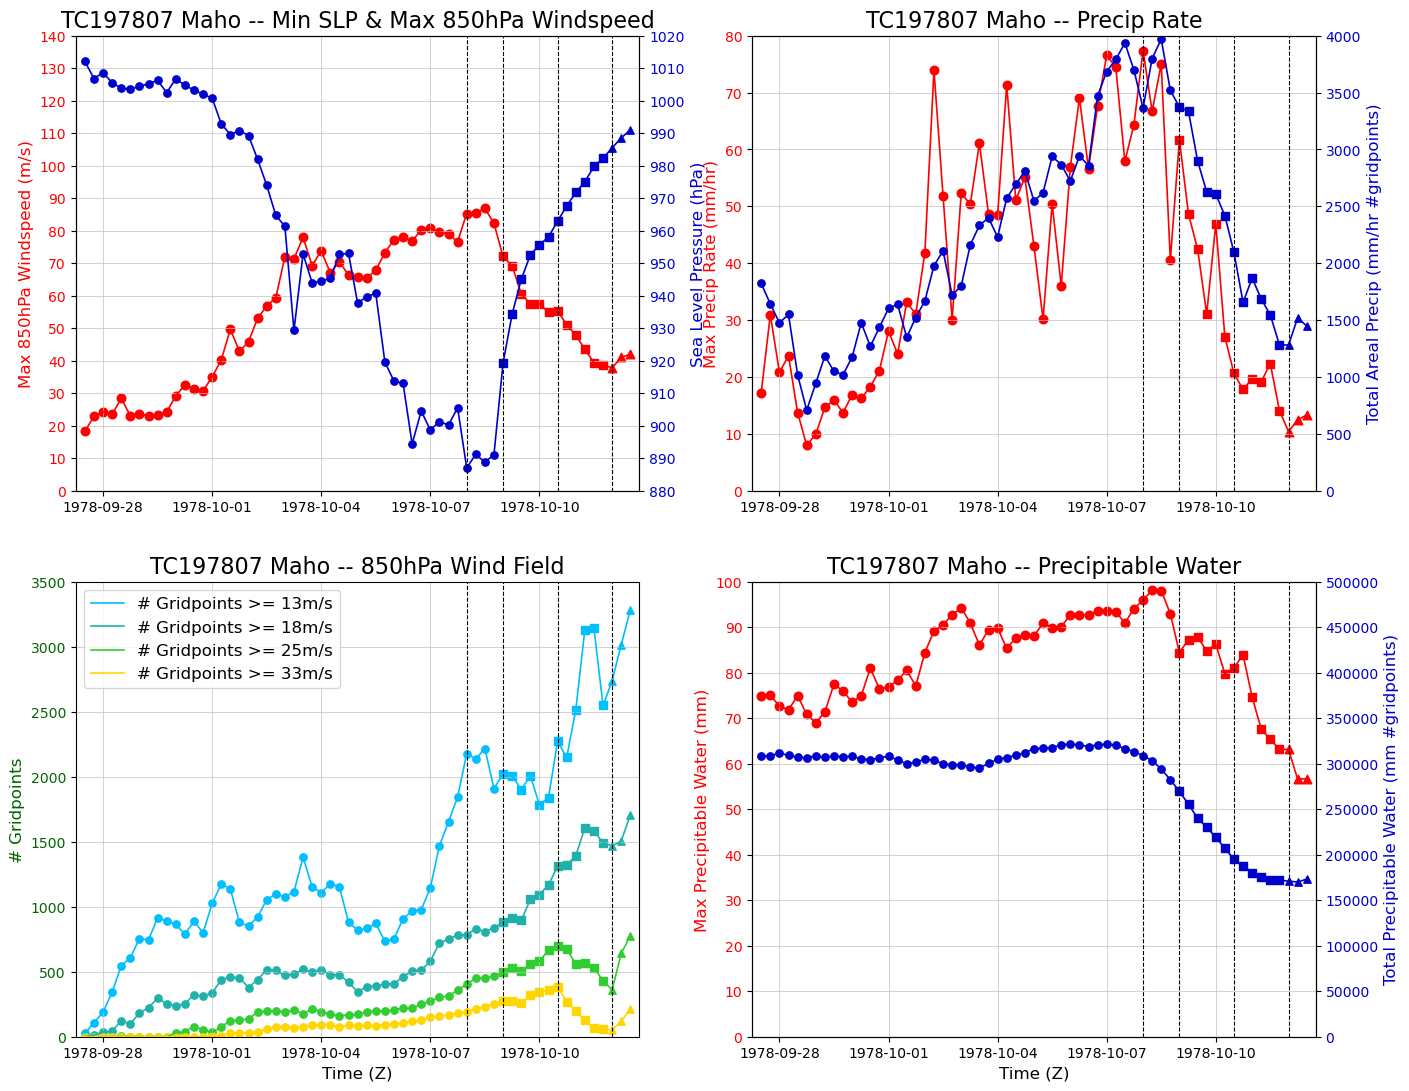

In [61]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

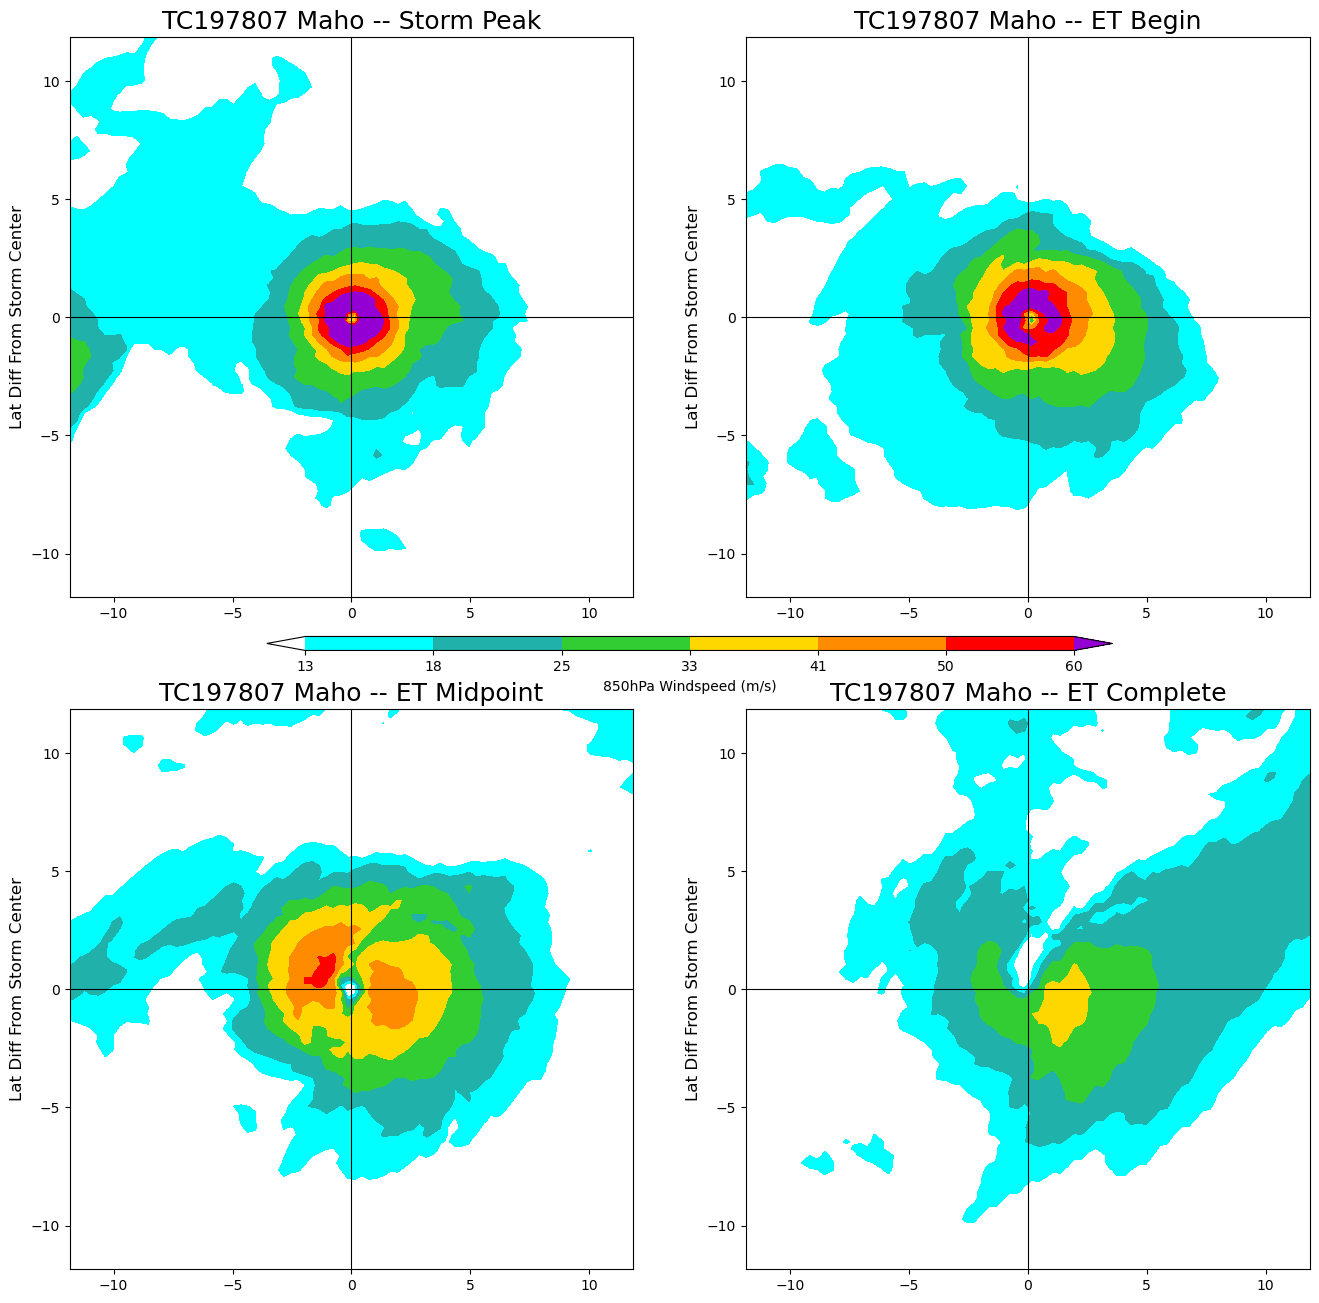

In [62]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

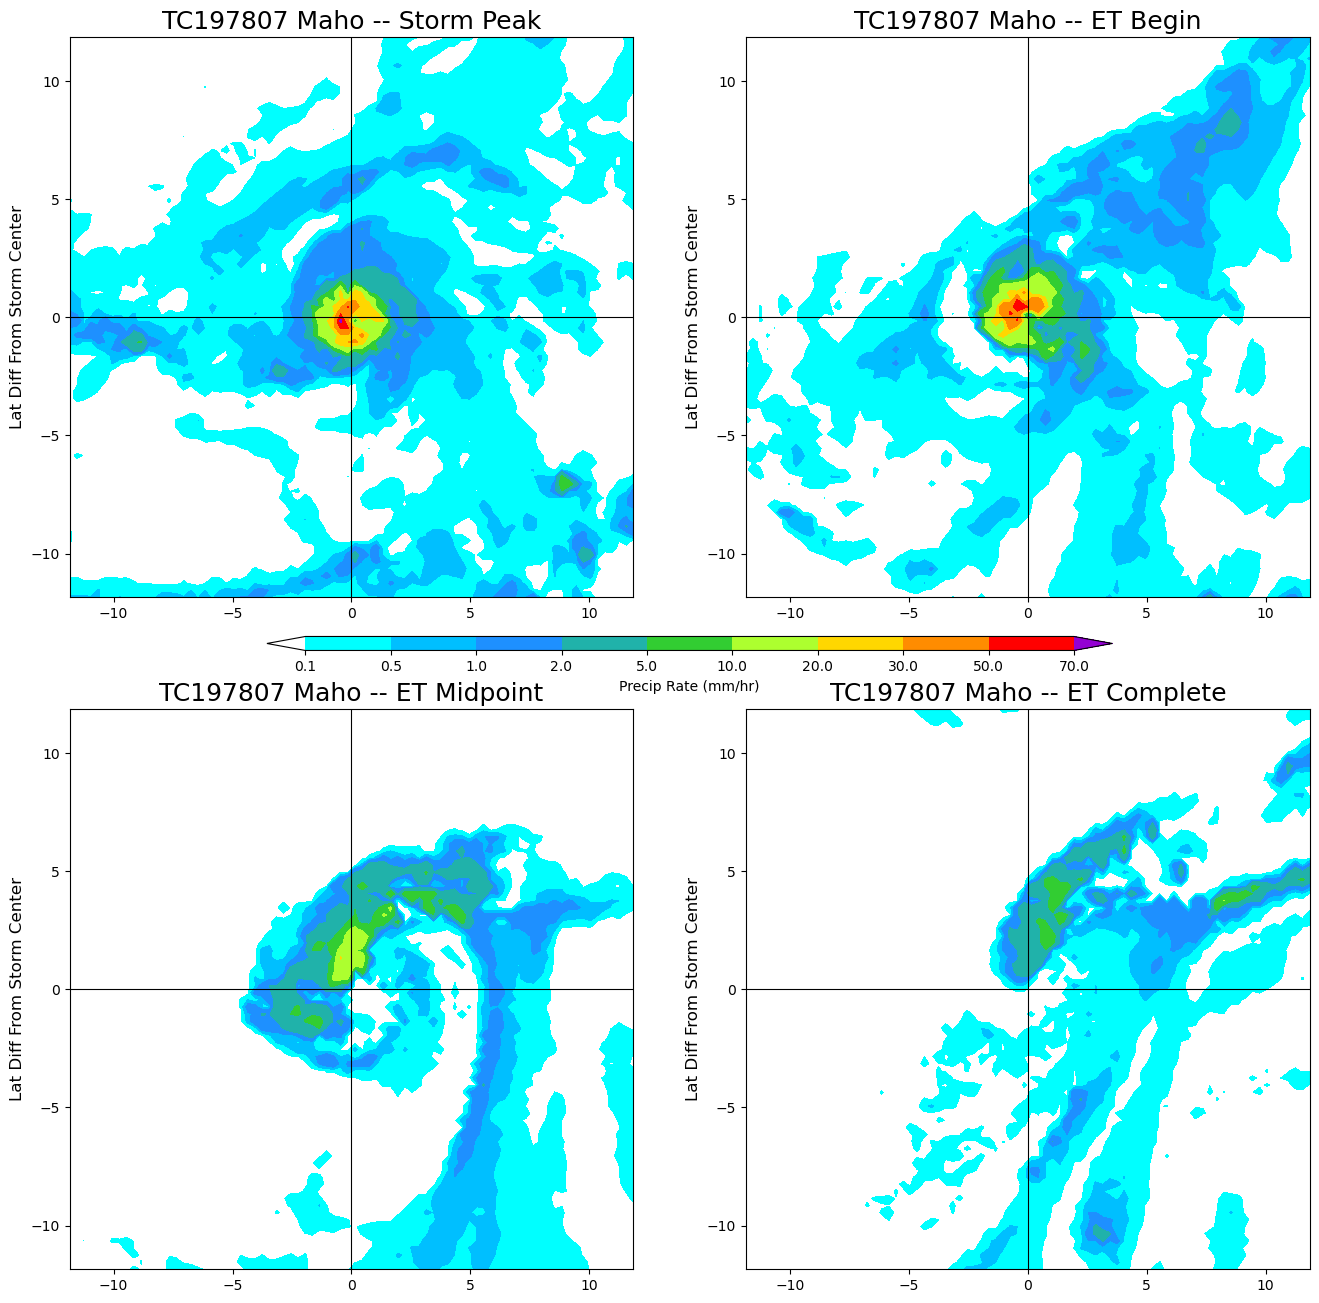

In [63]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

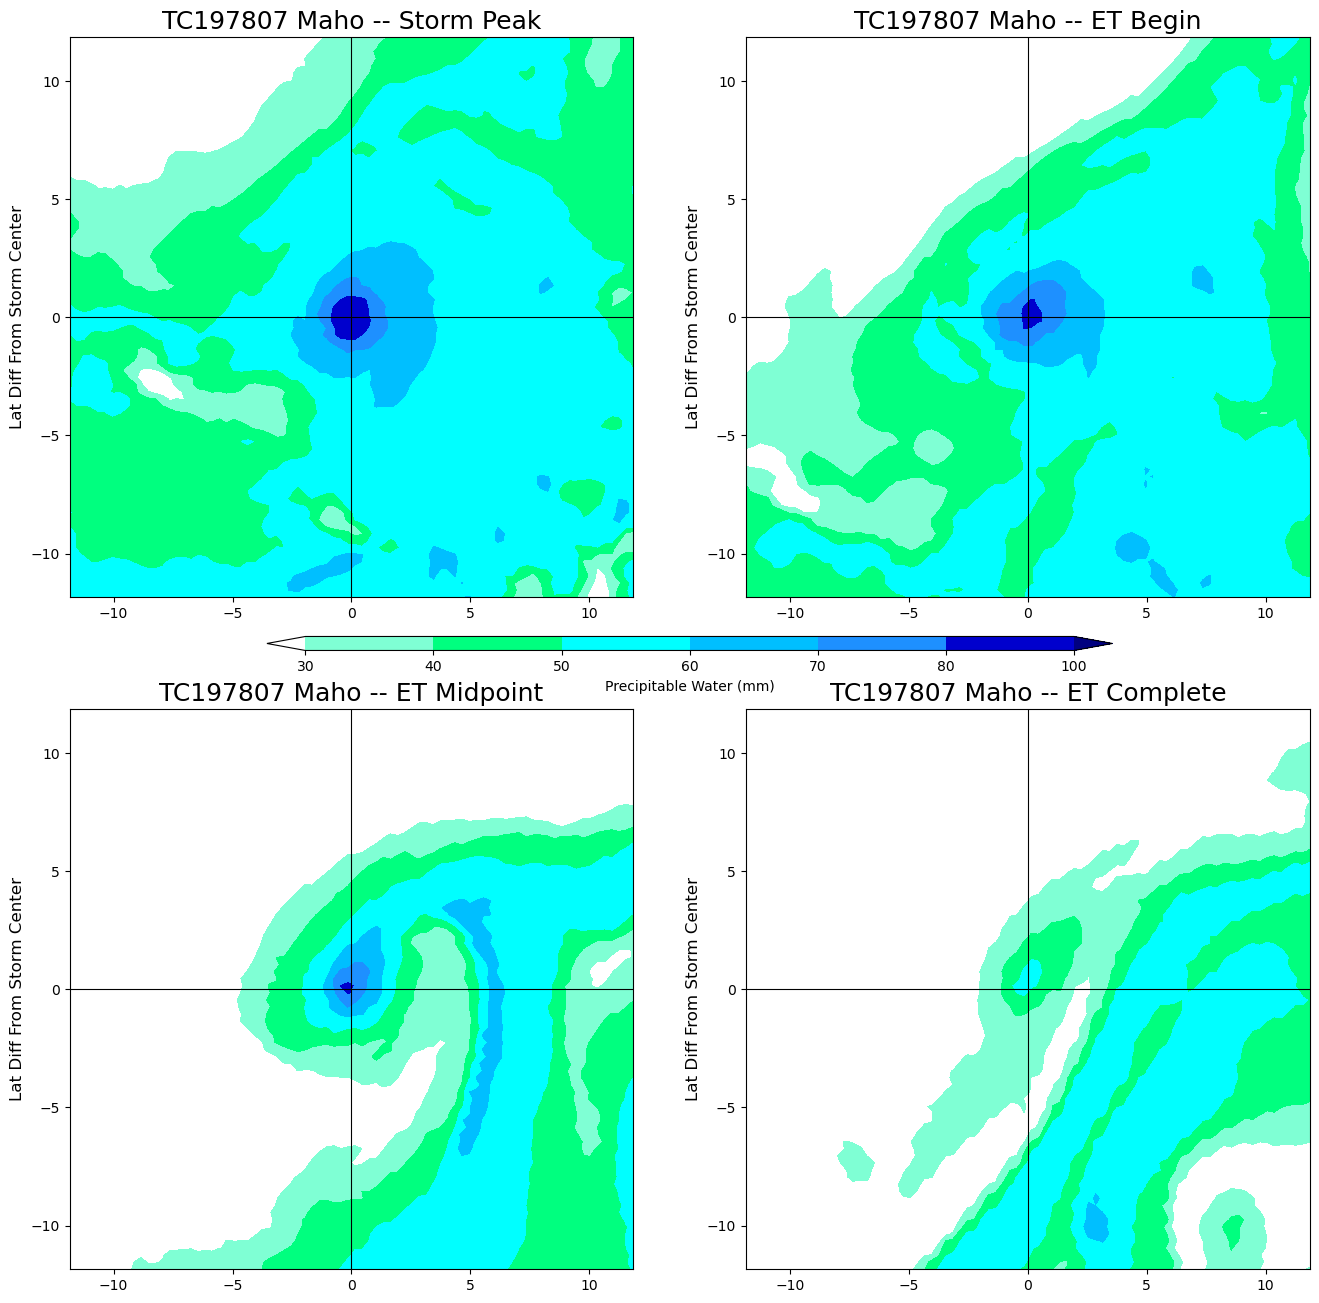

In [64]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [65]:
# Find Wind Field Composite Data
Code = "TC202006"
Storm_Name = "Grace"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_A_Compo_nc
Time_Indexes = [4652,4656,4657,4658]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [66]:
#DF_Storm_Compo_Wind_Field

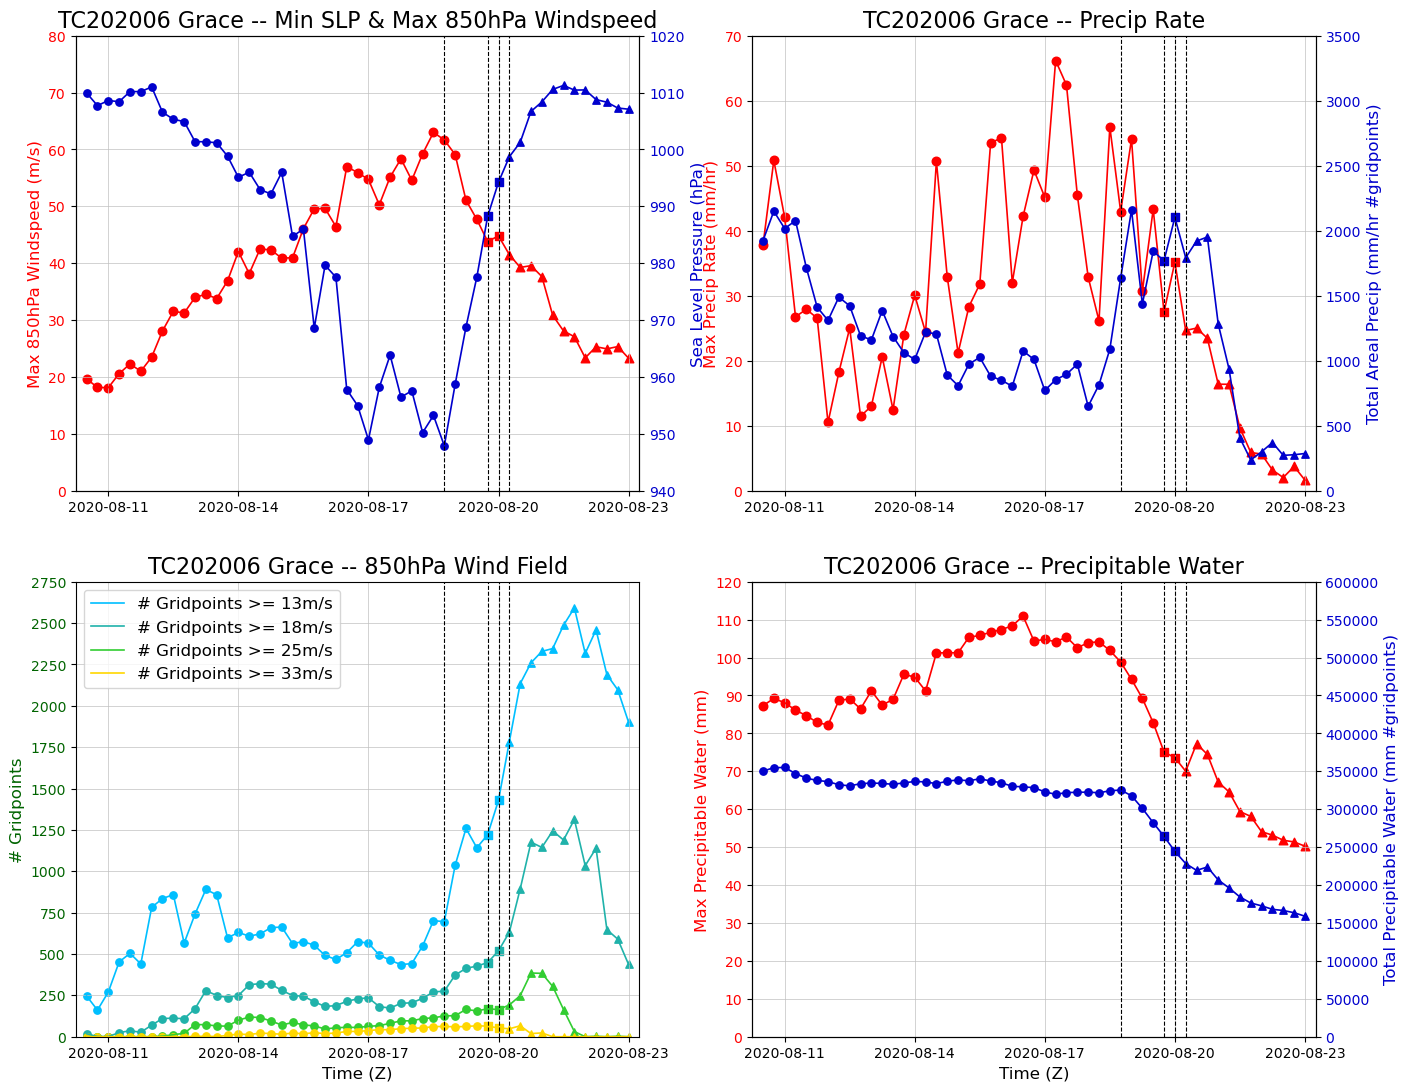

In [67]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

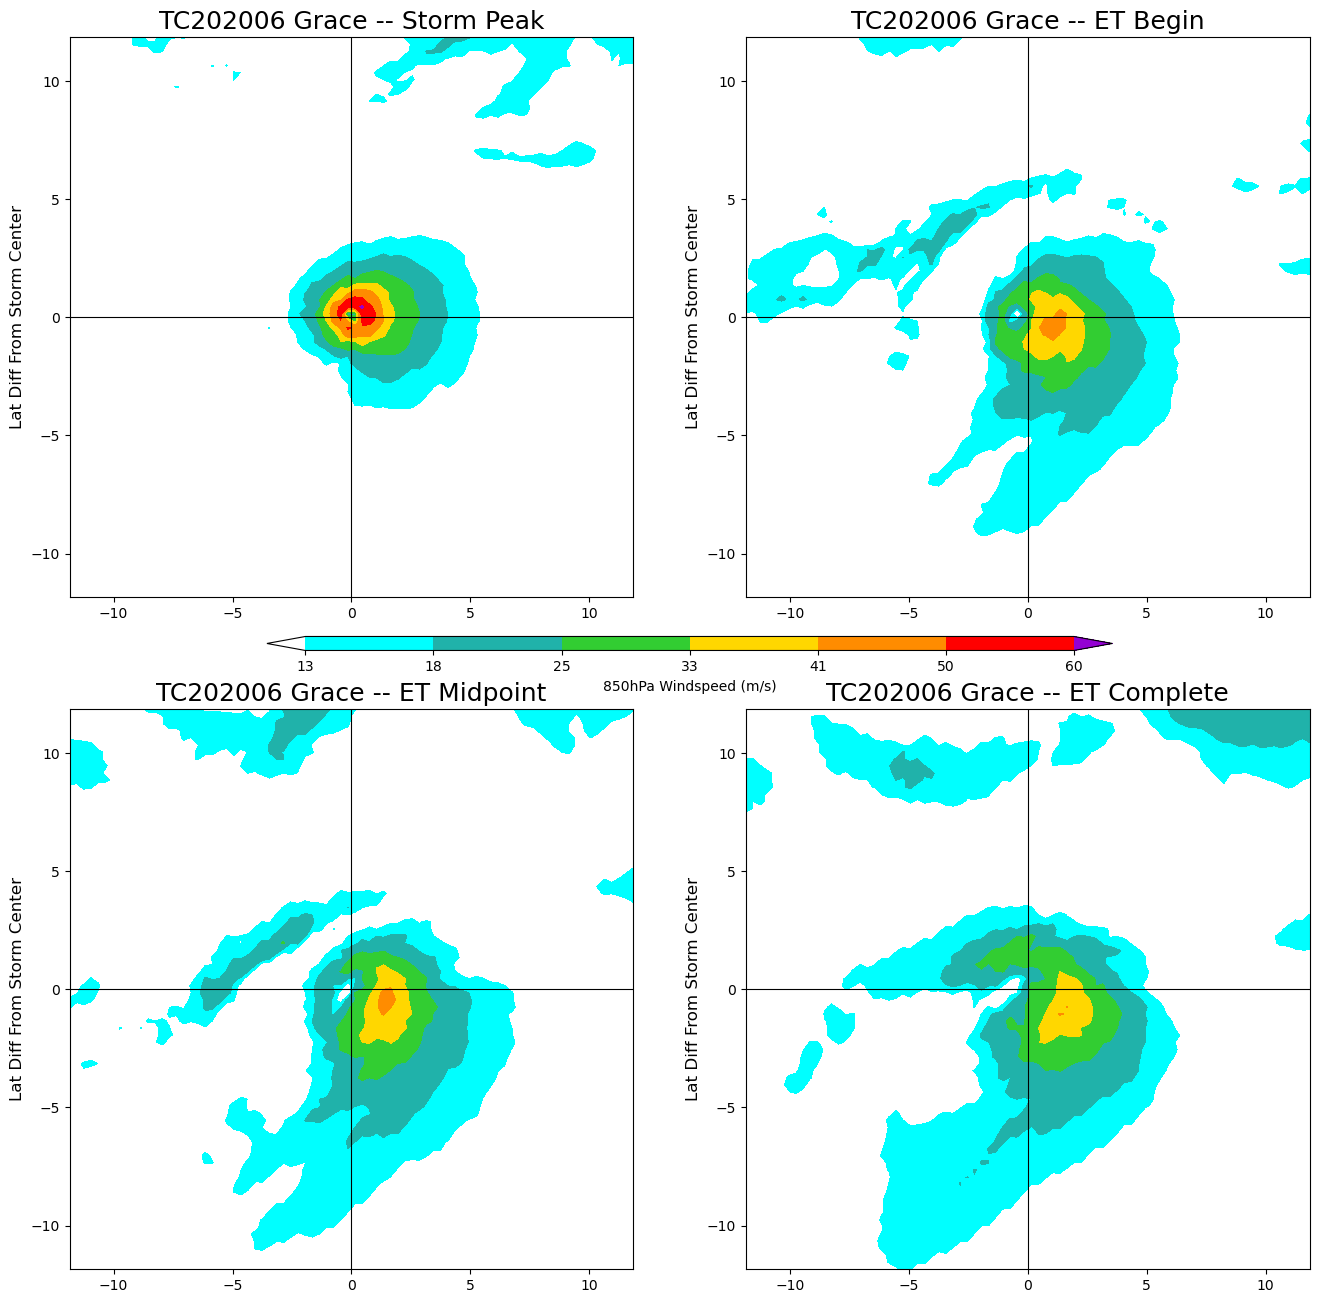

In [68]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

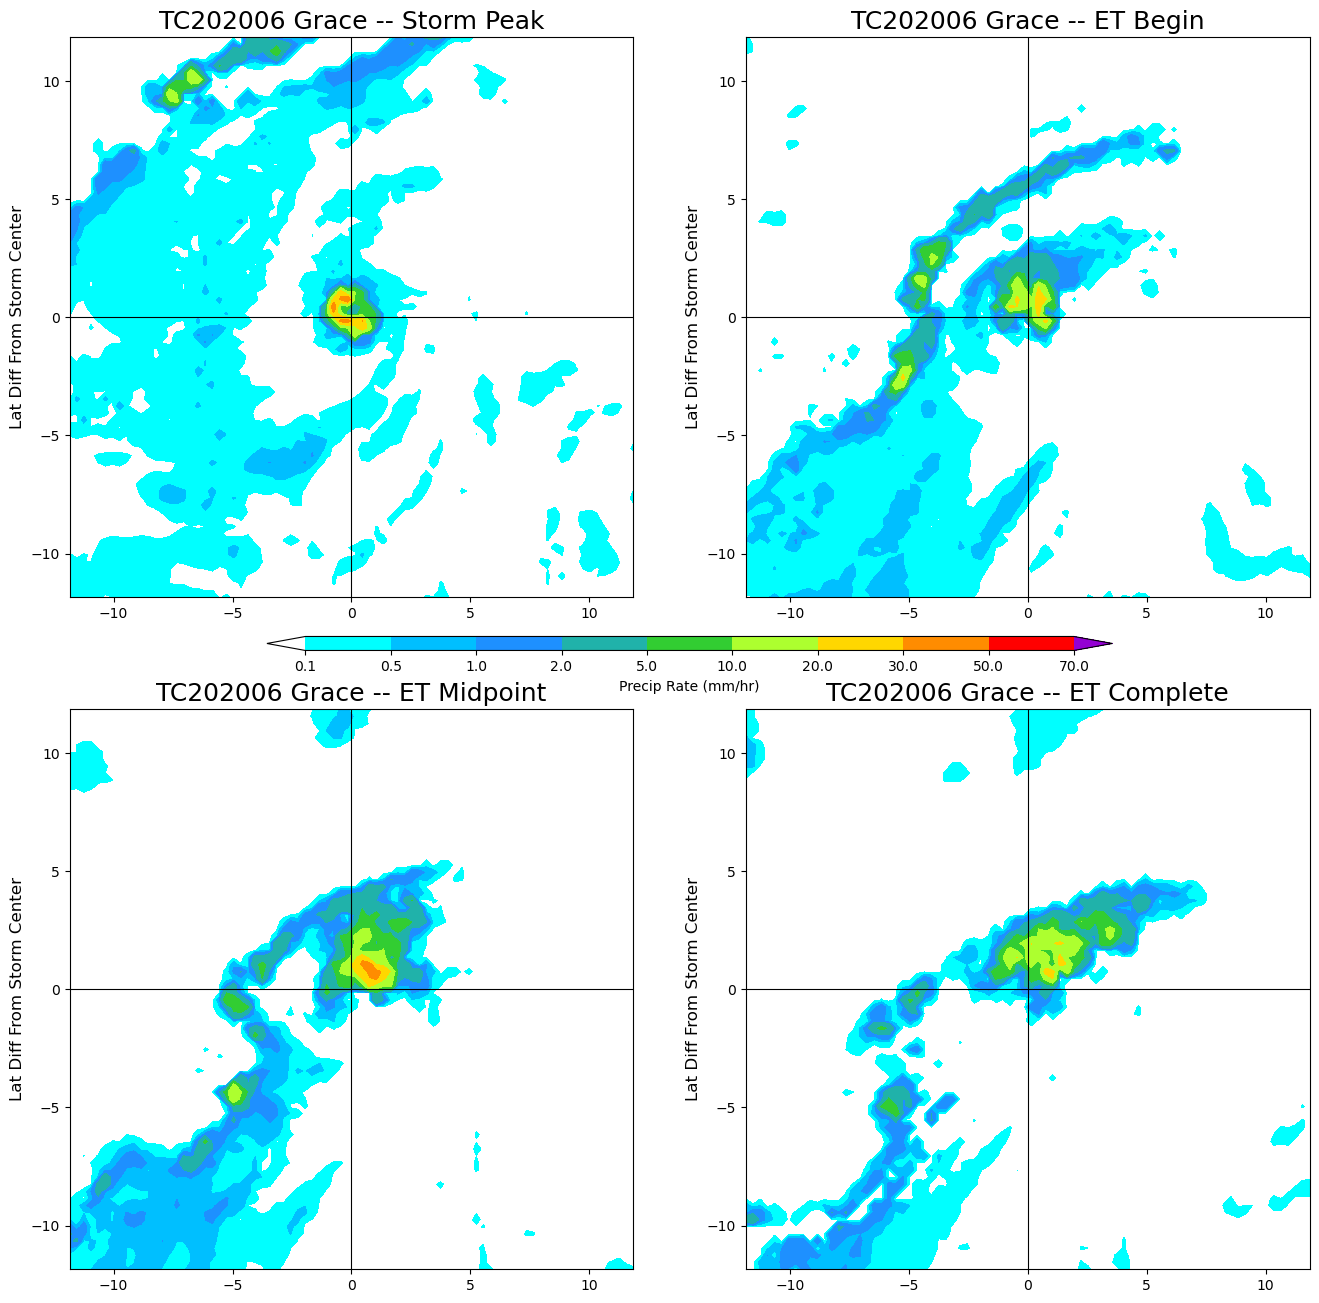

In [69]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

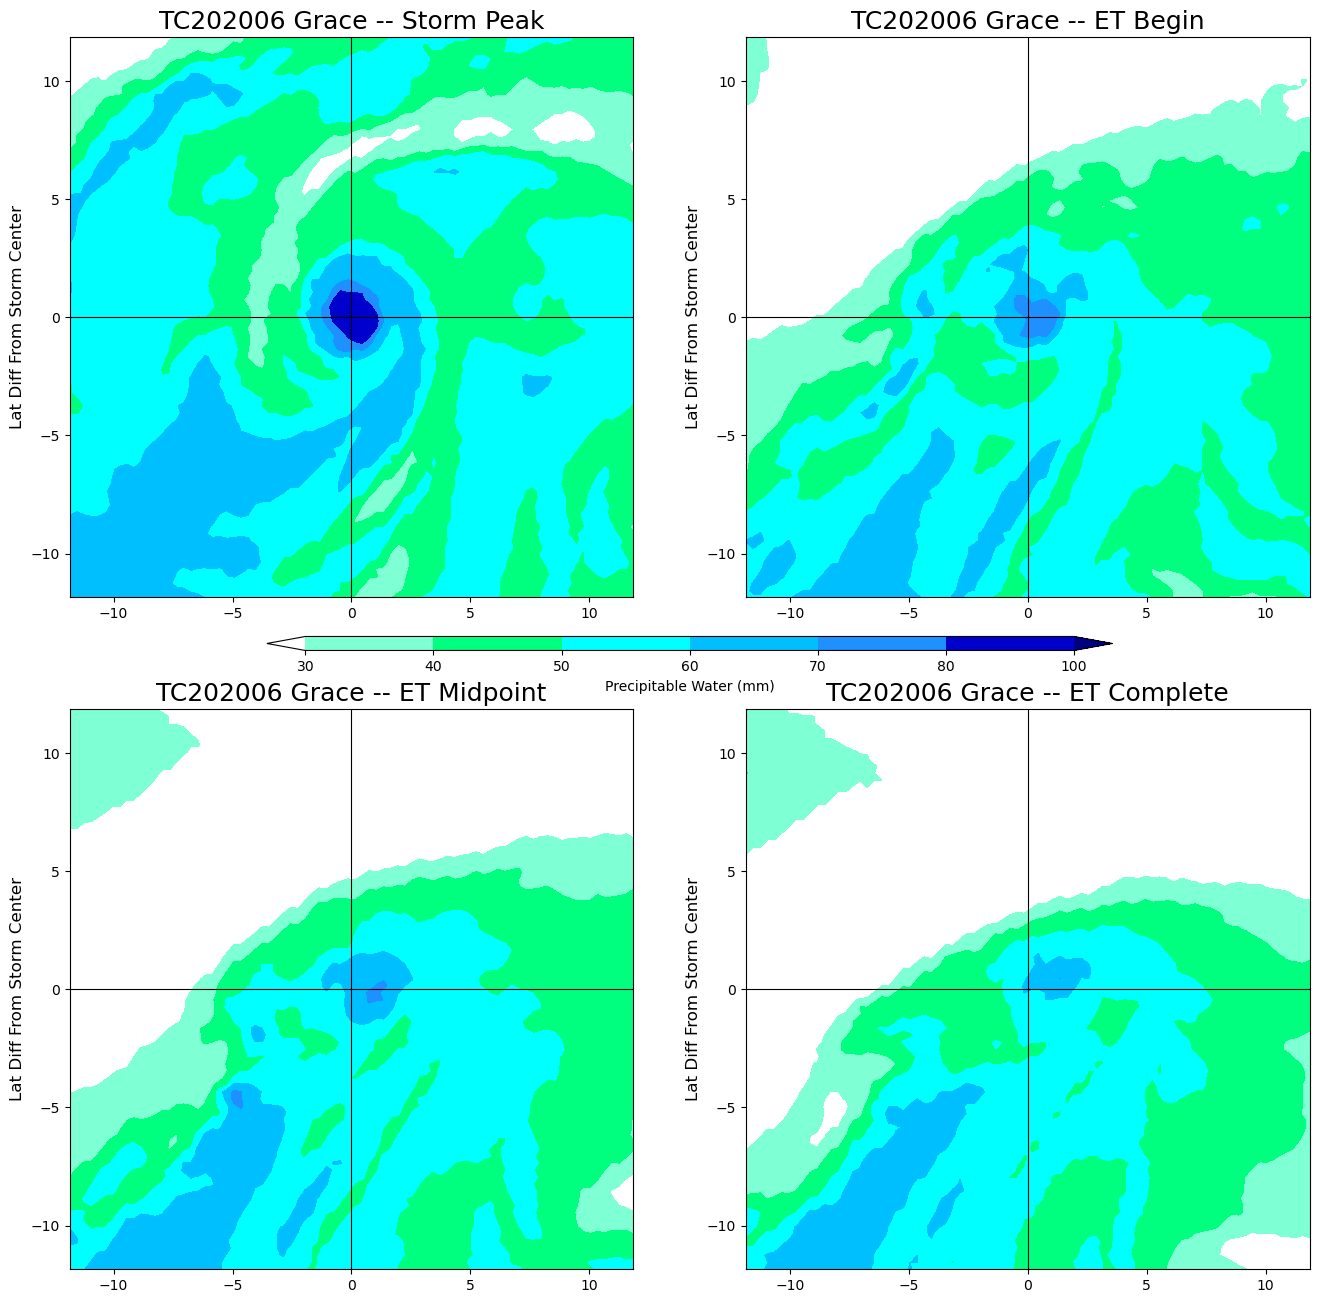

In [70]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [71]:
# Find Wind Field Composite Data
Code = "TC204702"
Storm_Name = "Esther"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_B_Compo_nc
Time_Indexes = [3570,3578,3582,3587]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [72]:
#DF_Storm_Compo_Wind_Field[40:]

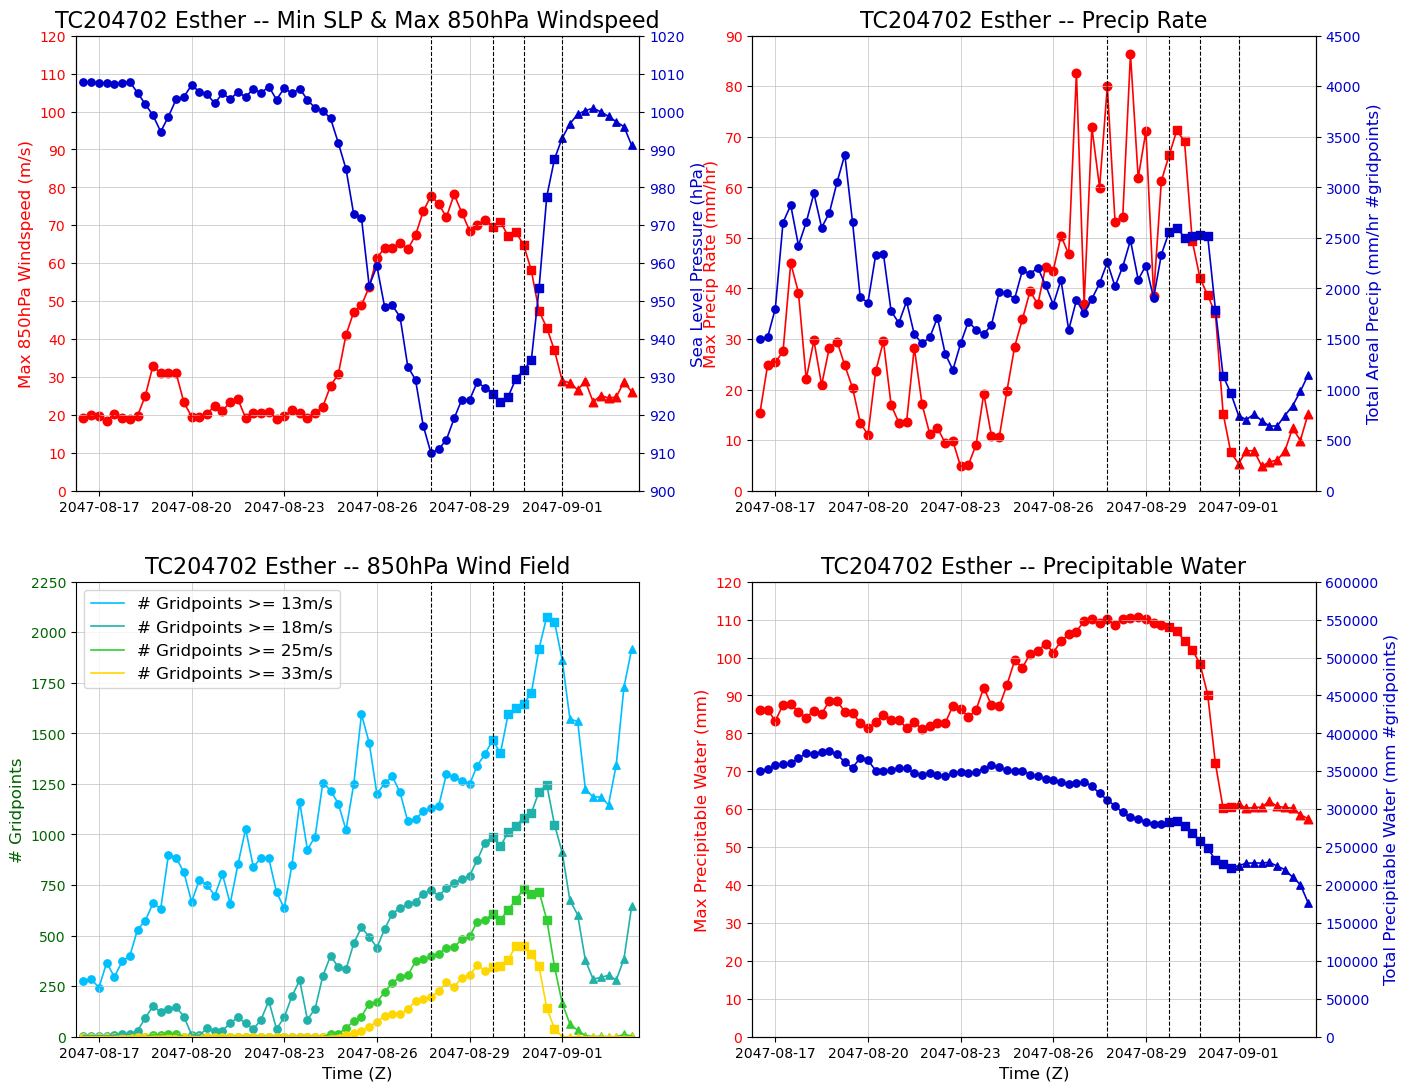

In [73]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

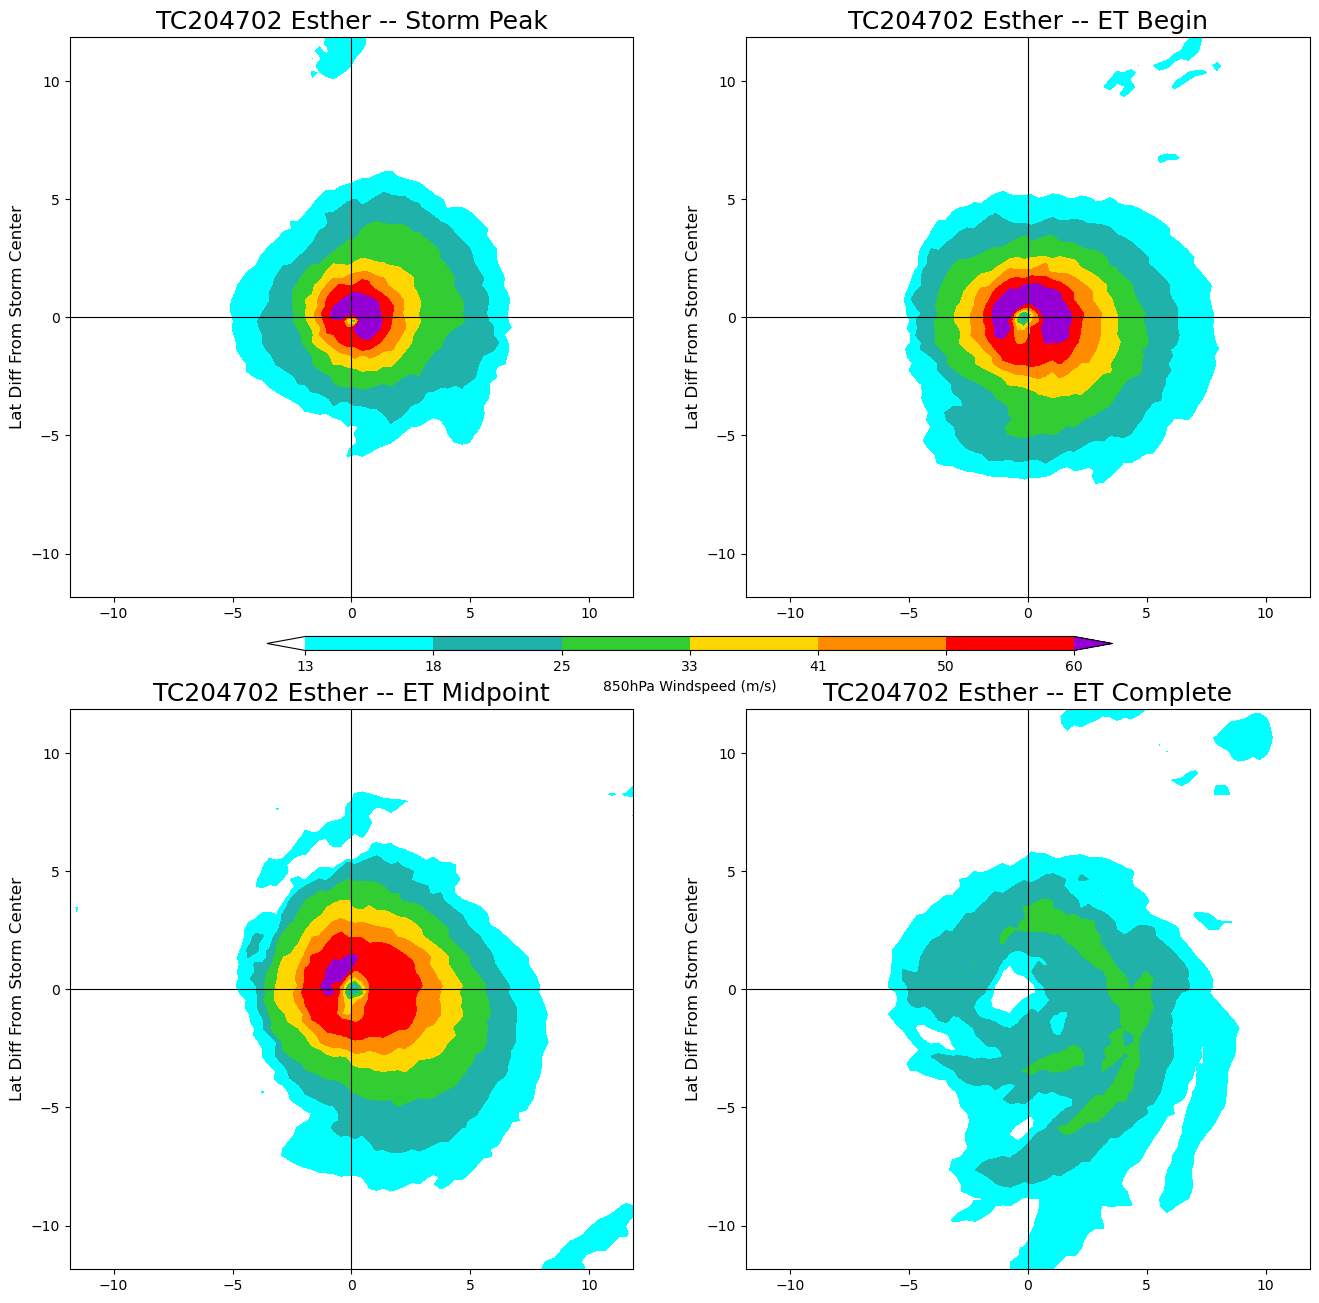

In [74]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

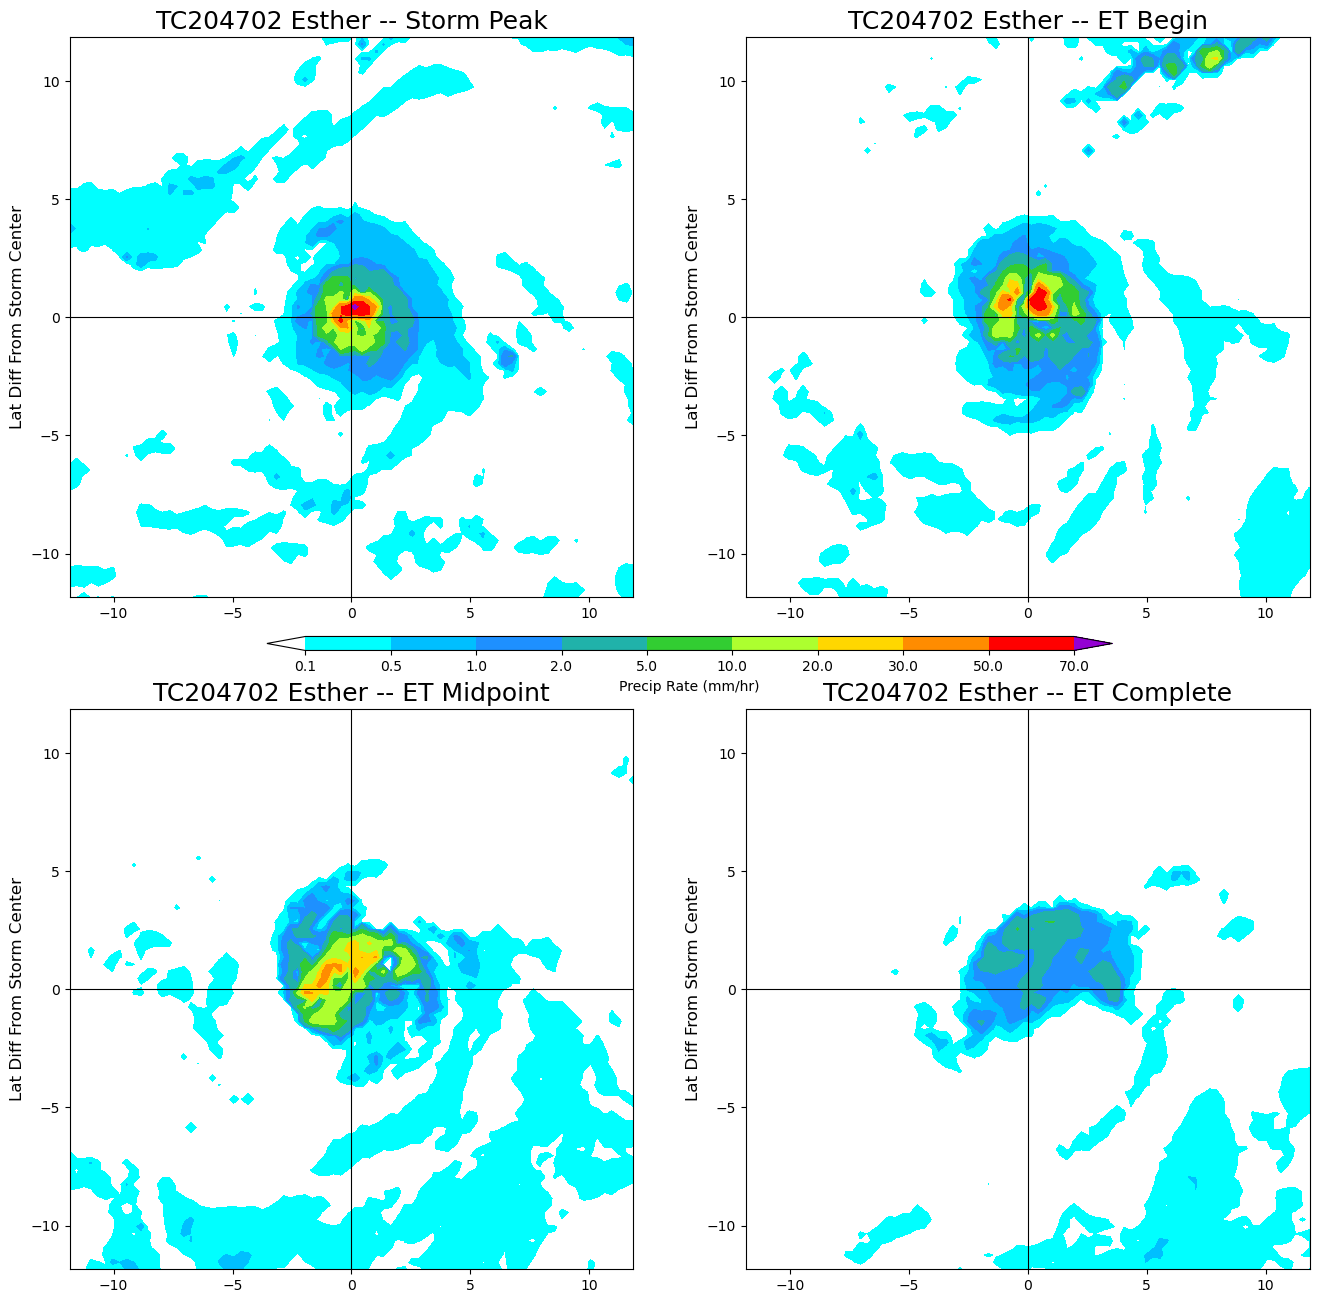

In [75]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

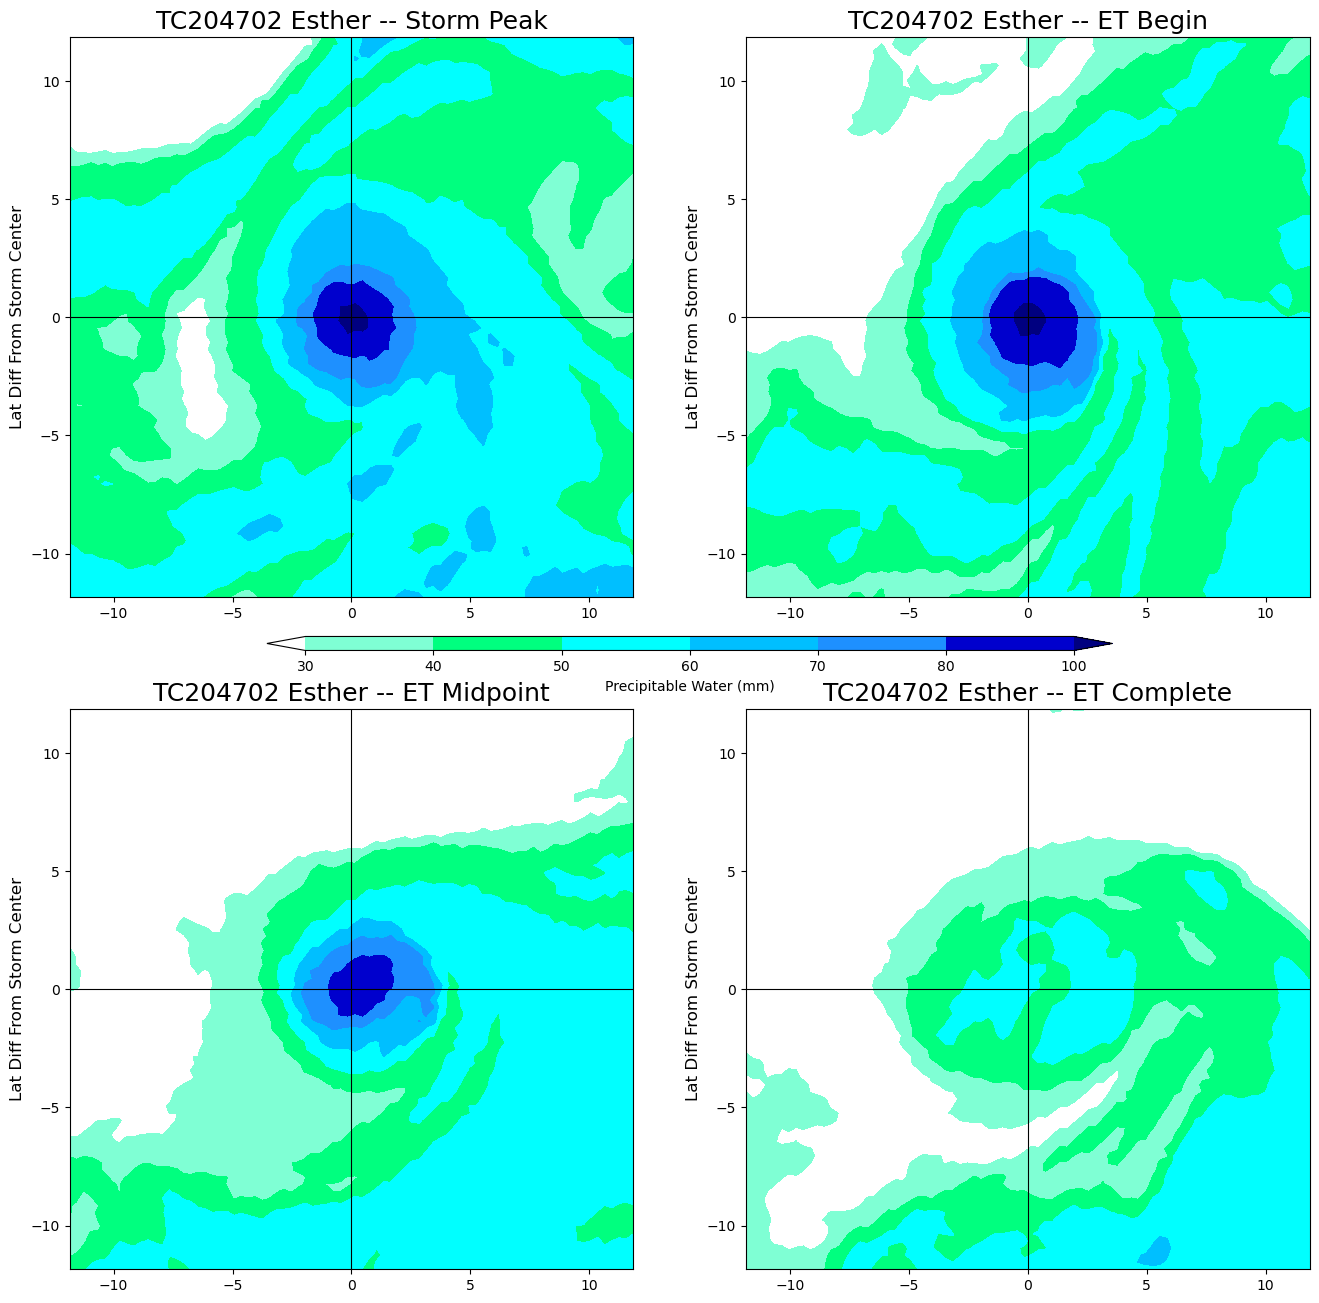

In [76]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [77]:
# Find Wind Field Composite Data
Code = "TC208507"
Storm_Name = "Shannon"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_C_Compo_nc
Time_Indexes = [5820,5826,5828,5830]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [78]:
#DF_Storm_Compo_Wind_Field

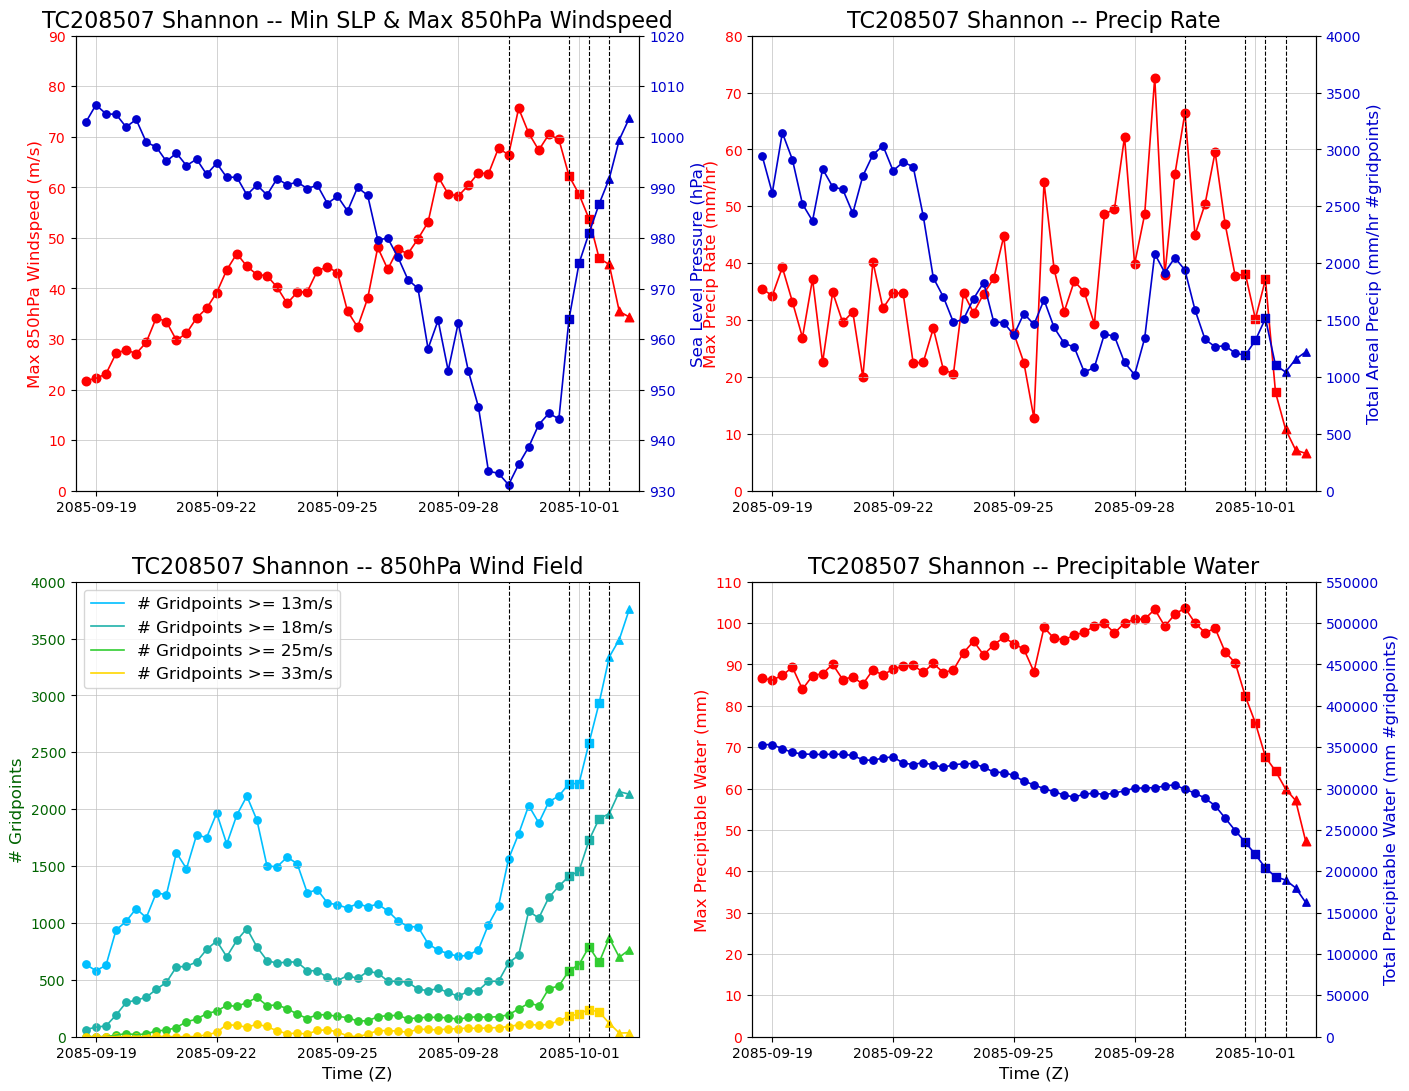

In [79]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

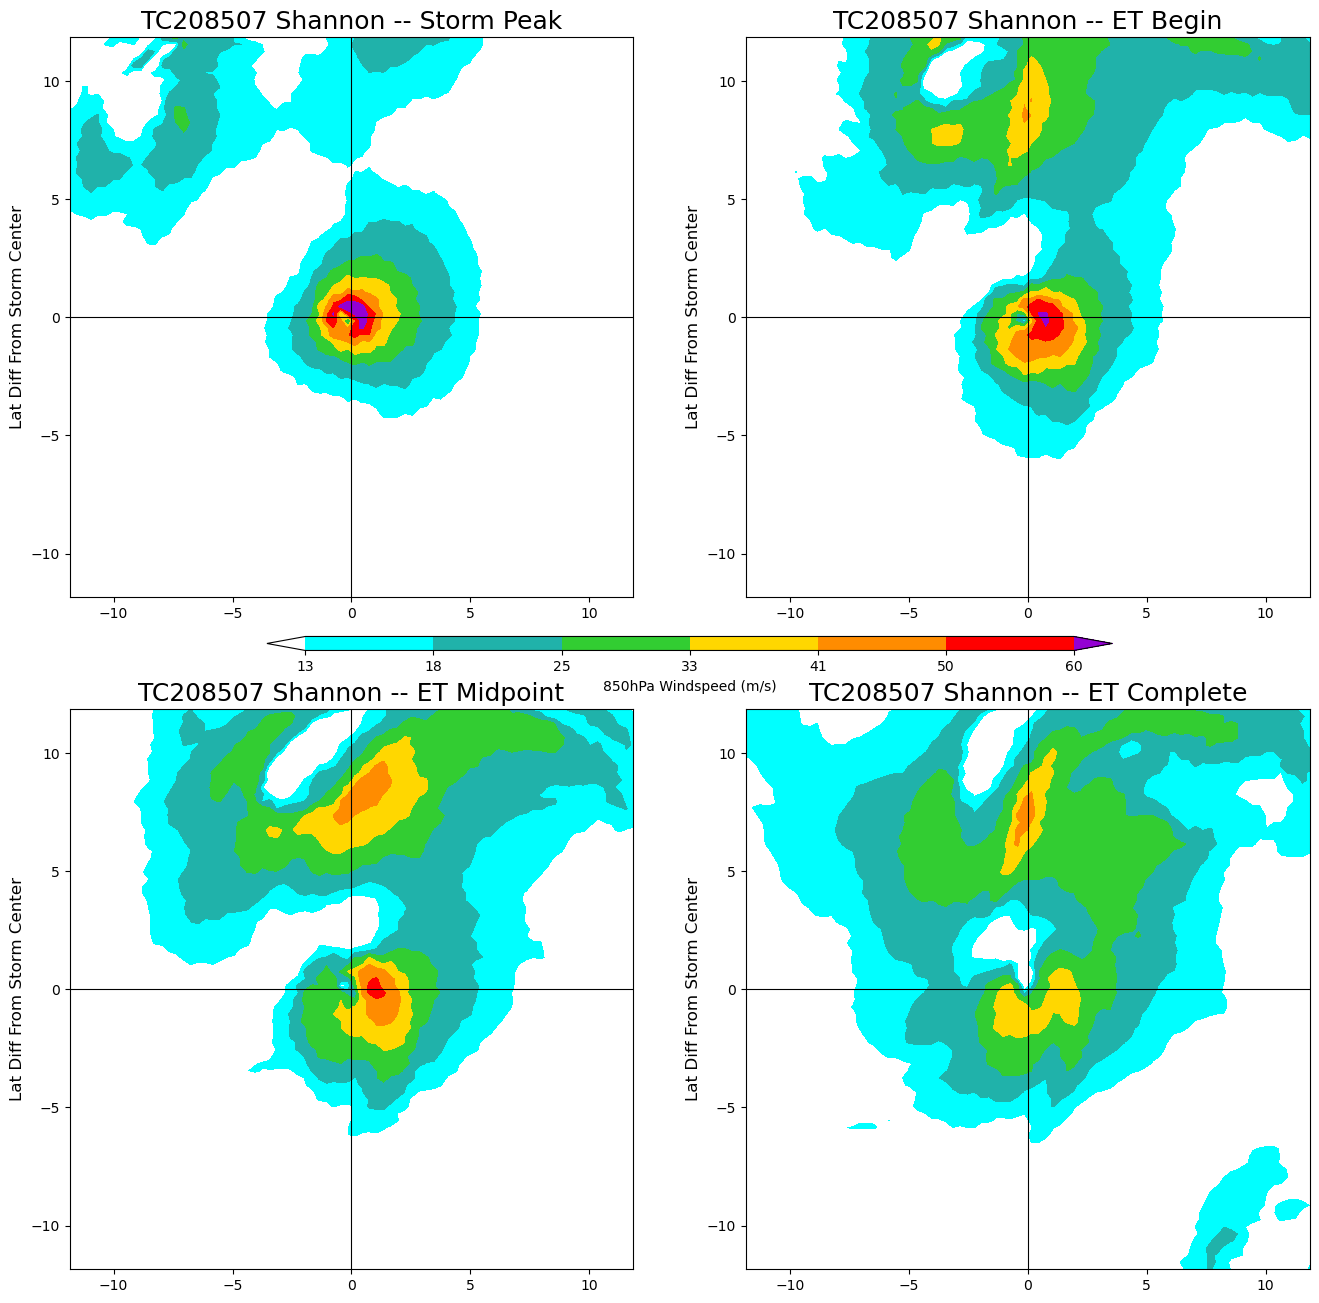

In [80]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

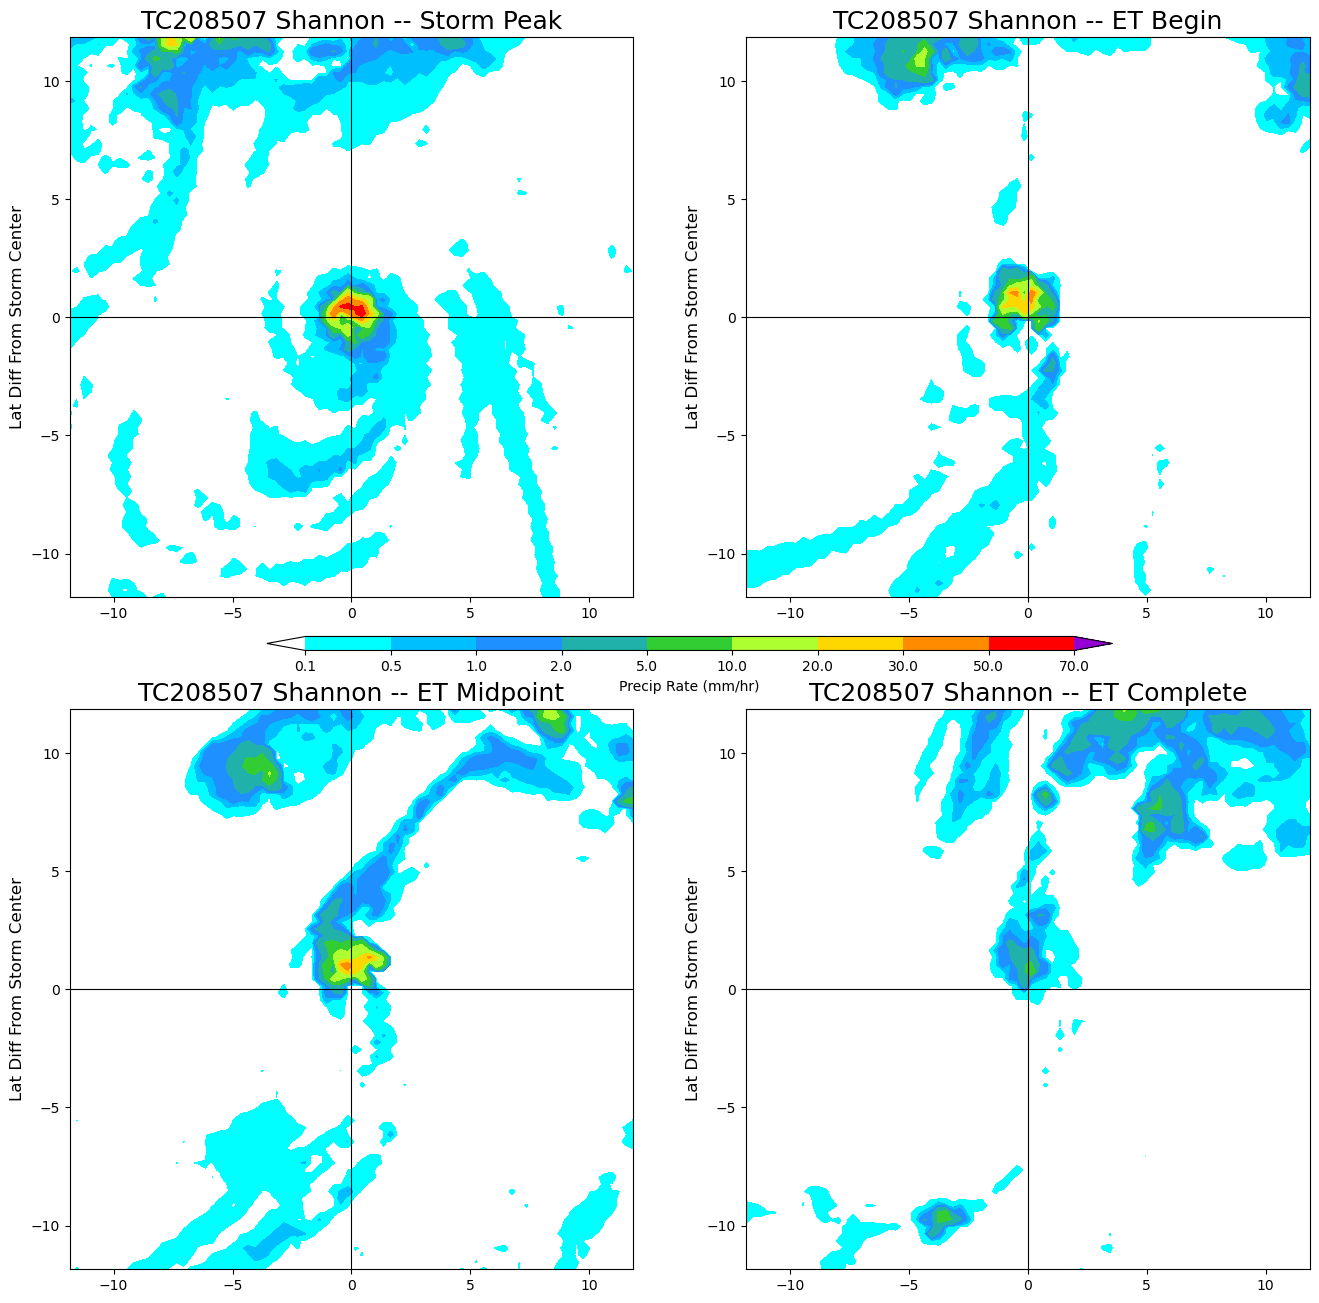

In [81]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

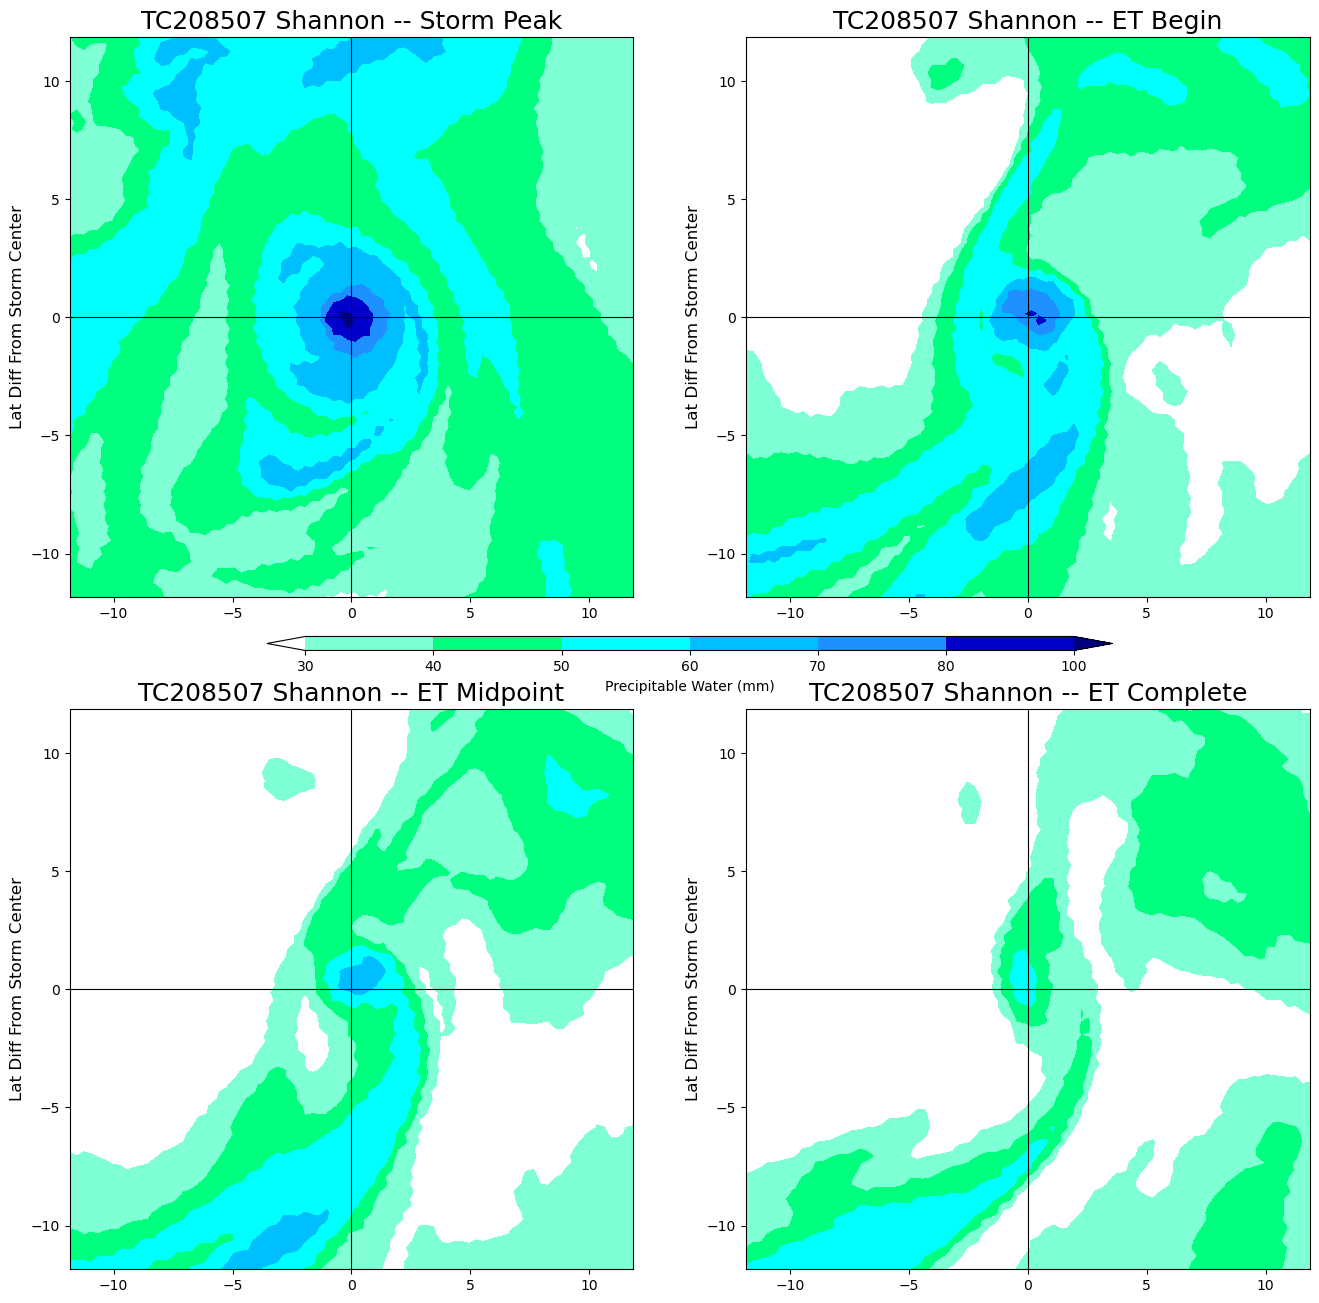

In [82]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [83]:
# Find Wind Field Composite Data
Code = "TC210105"
Storm_Name = "Nicole"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_A_Compo_nc
Time_Indexes = [323,339,343,347]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [84]:
#DF_Storm_Compo_Wind_Field

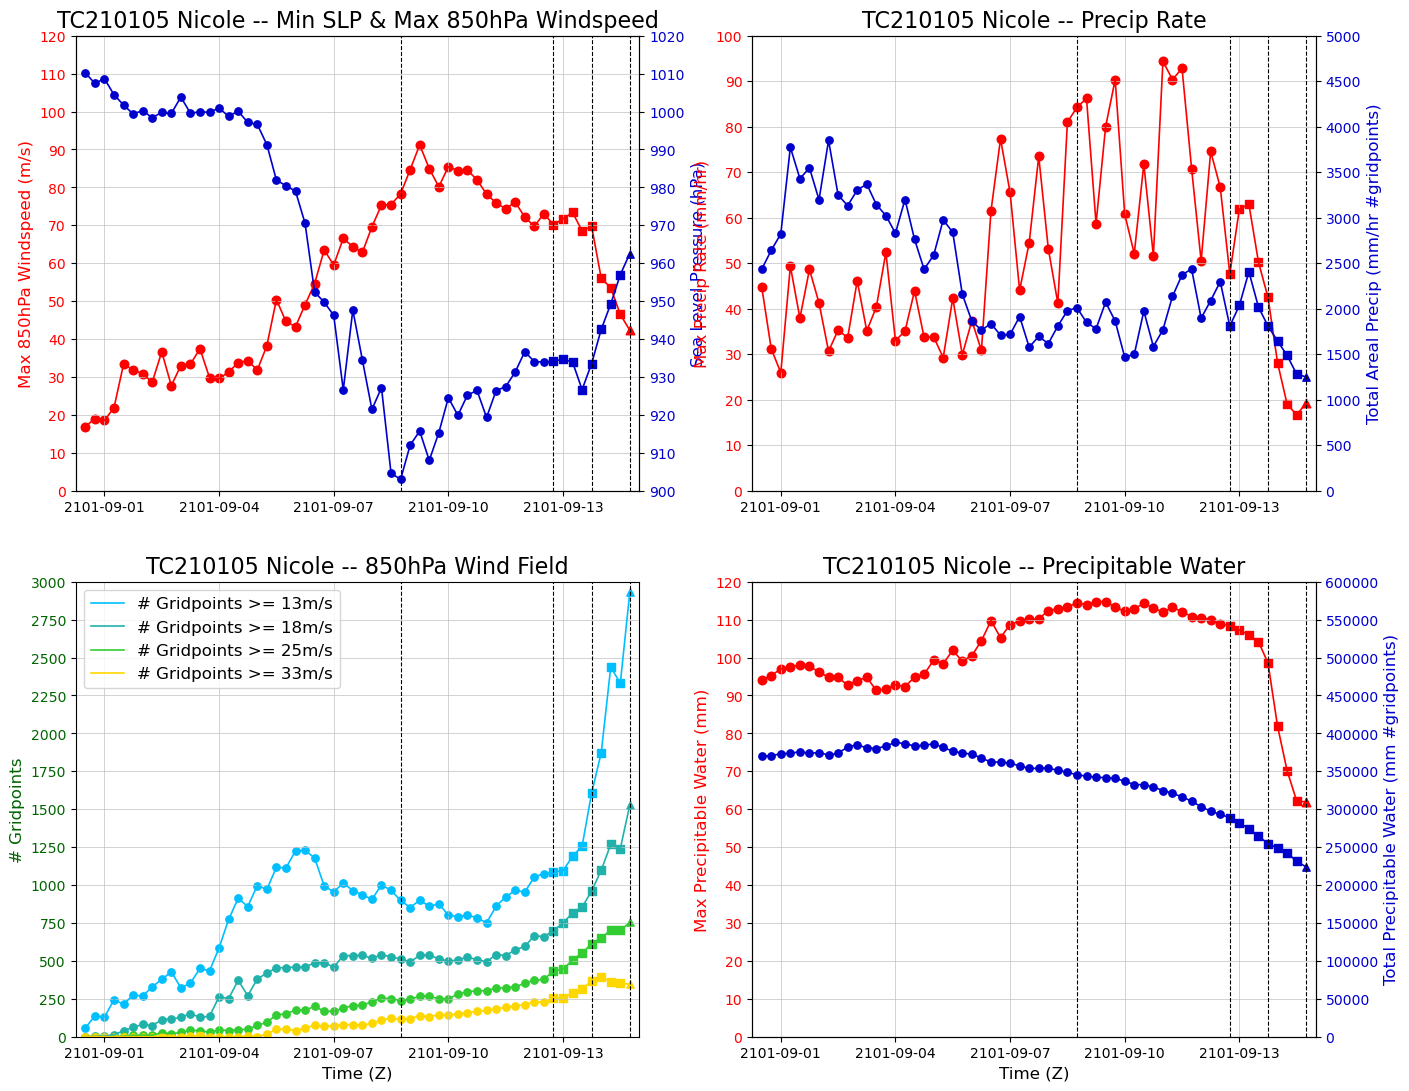

In [85]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

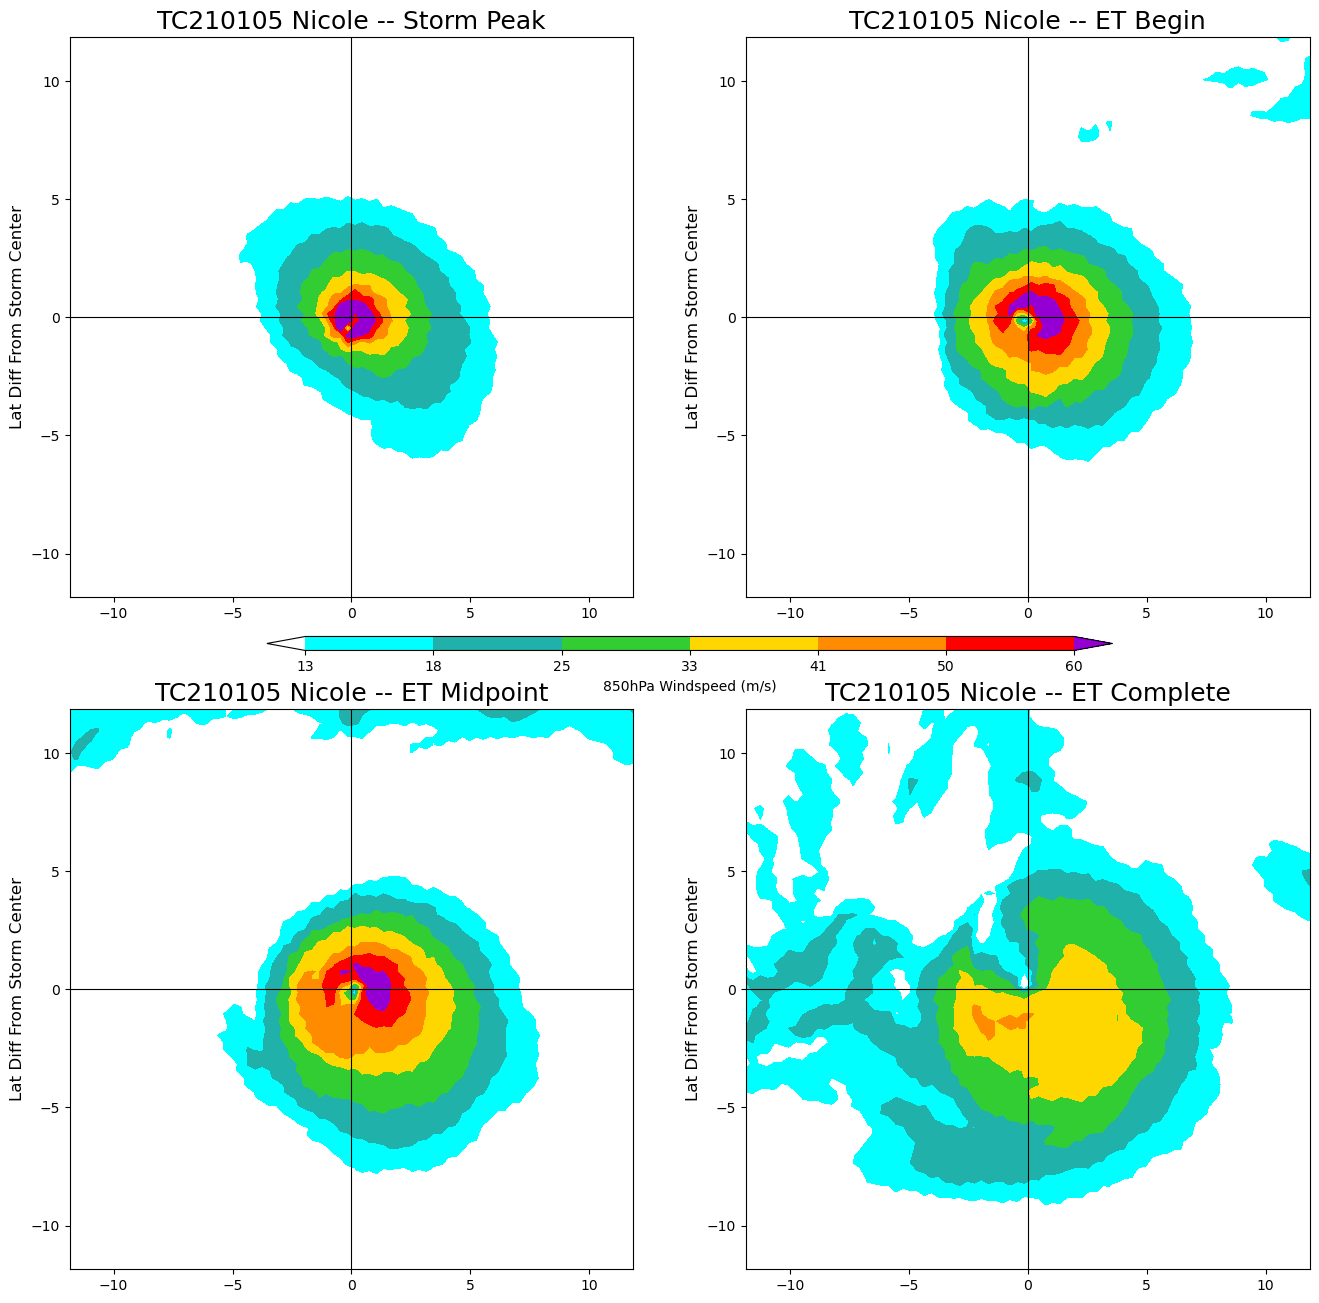

In [86]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

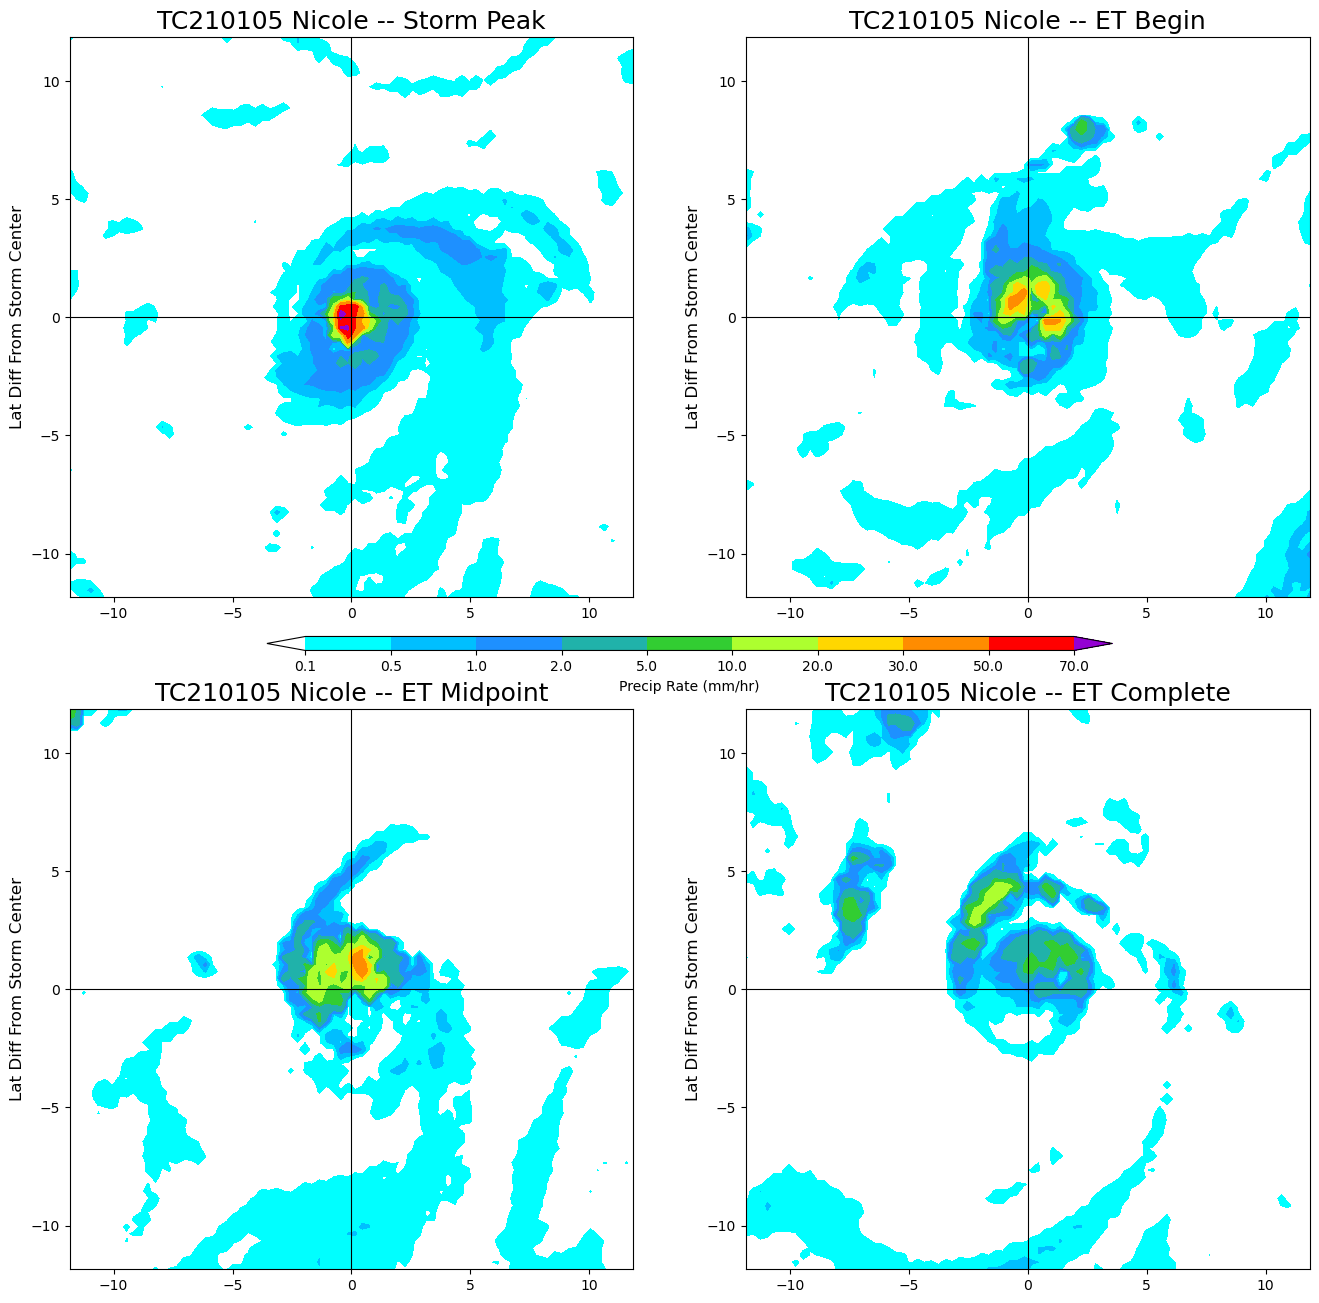

In [87]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

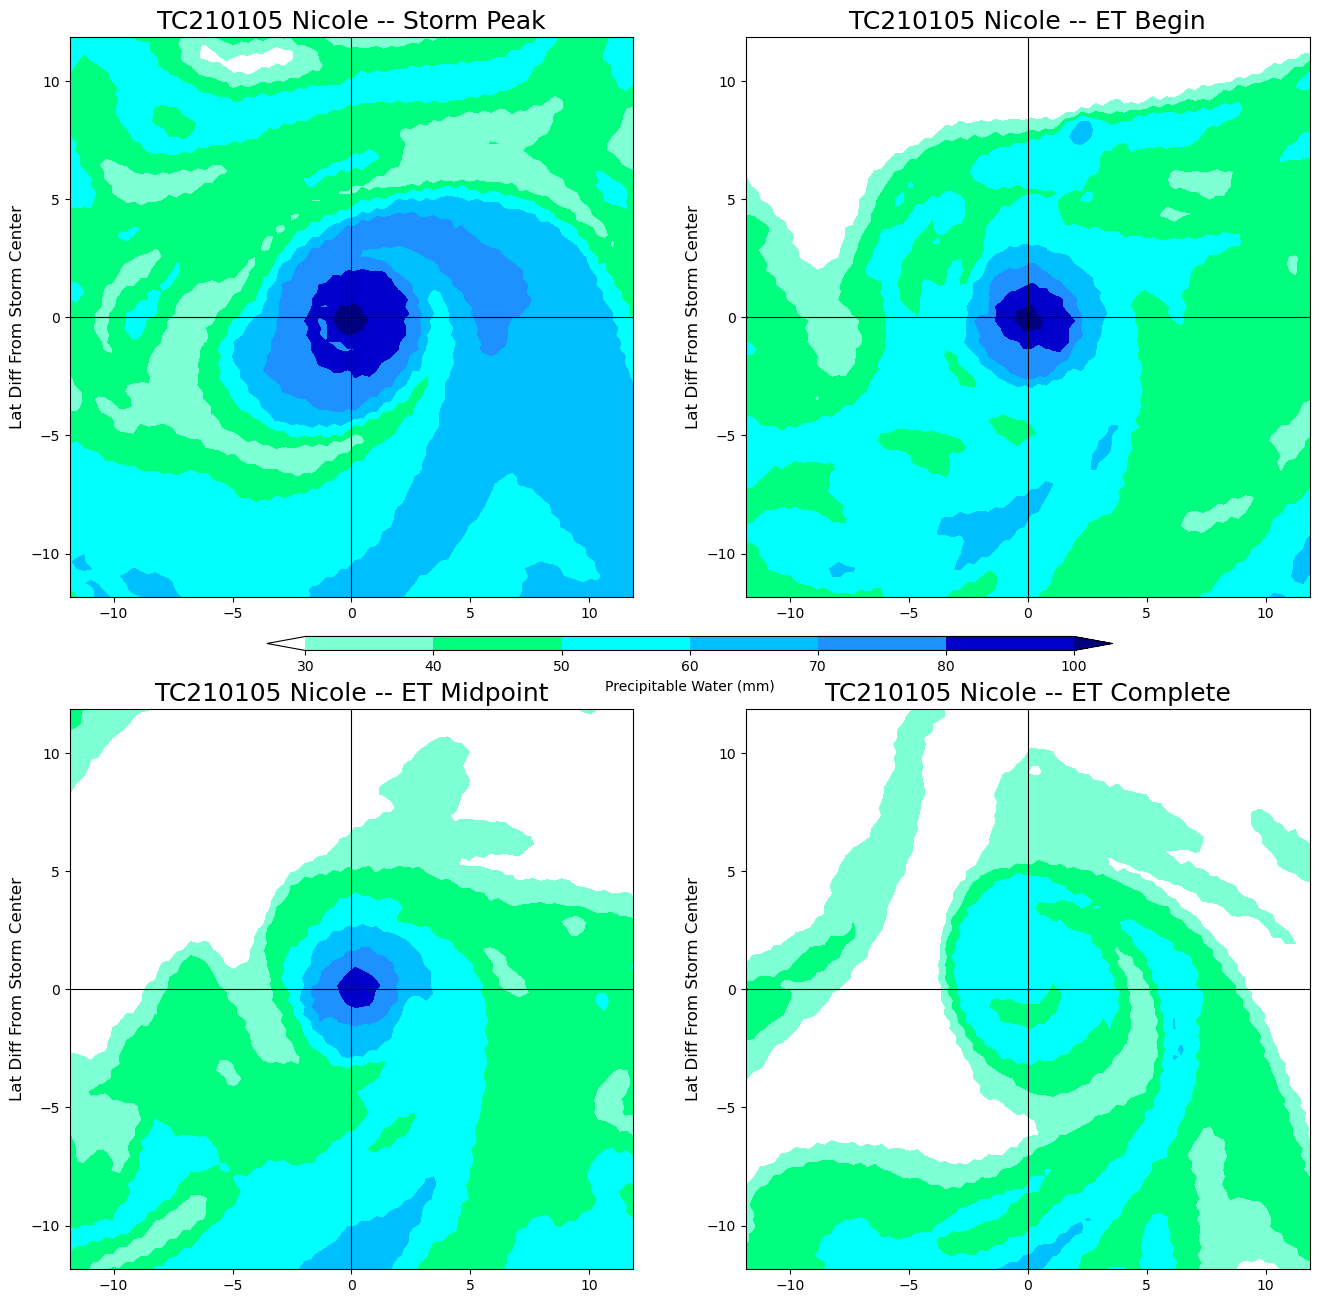

In [88]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [89]:
# Find Wind Field Composite Data
Code = "TC213903"
Storm_Name = "Kyan"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_B_Compo_nc
Time_Indexes = [1888,1890,1893,1896]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [90]:
#DF_Storm_Compo_Wind_Field

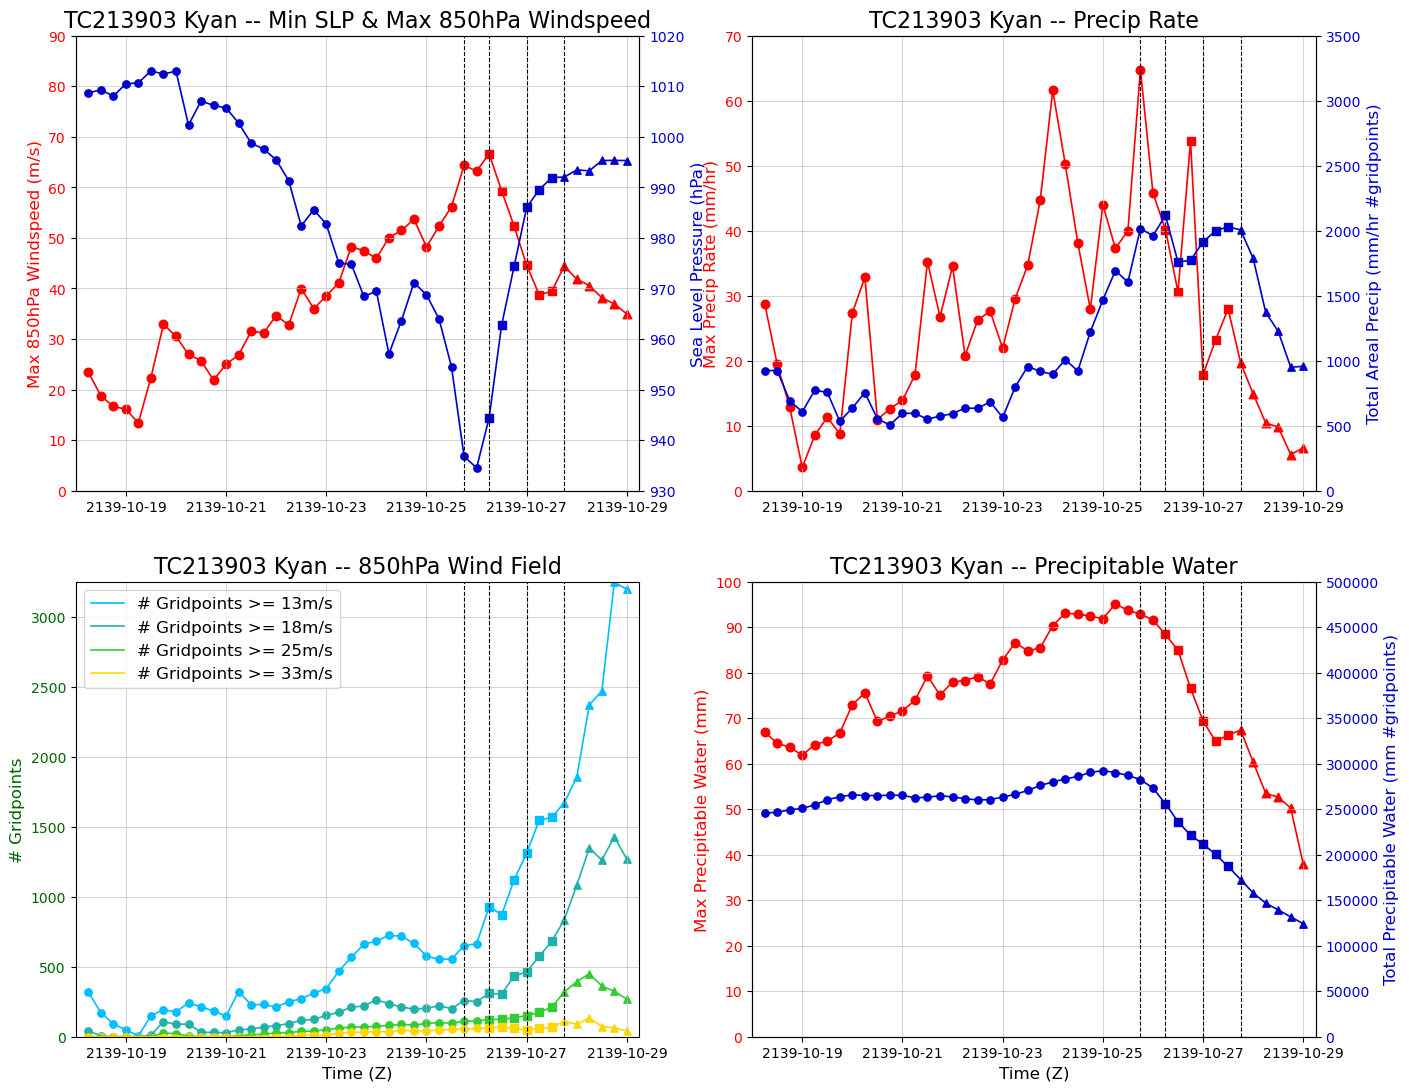

In [91]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

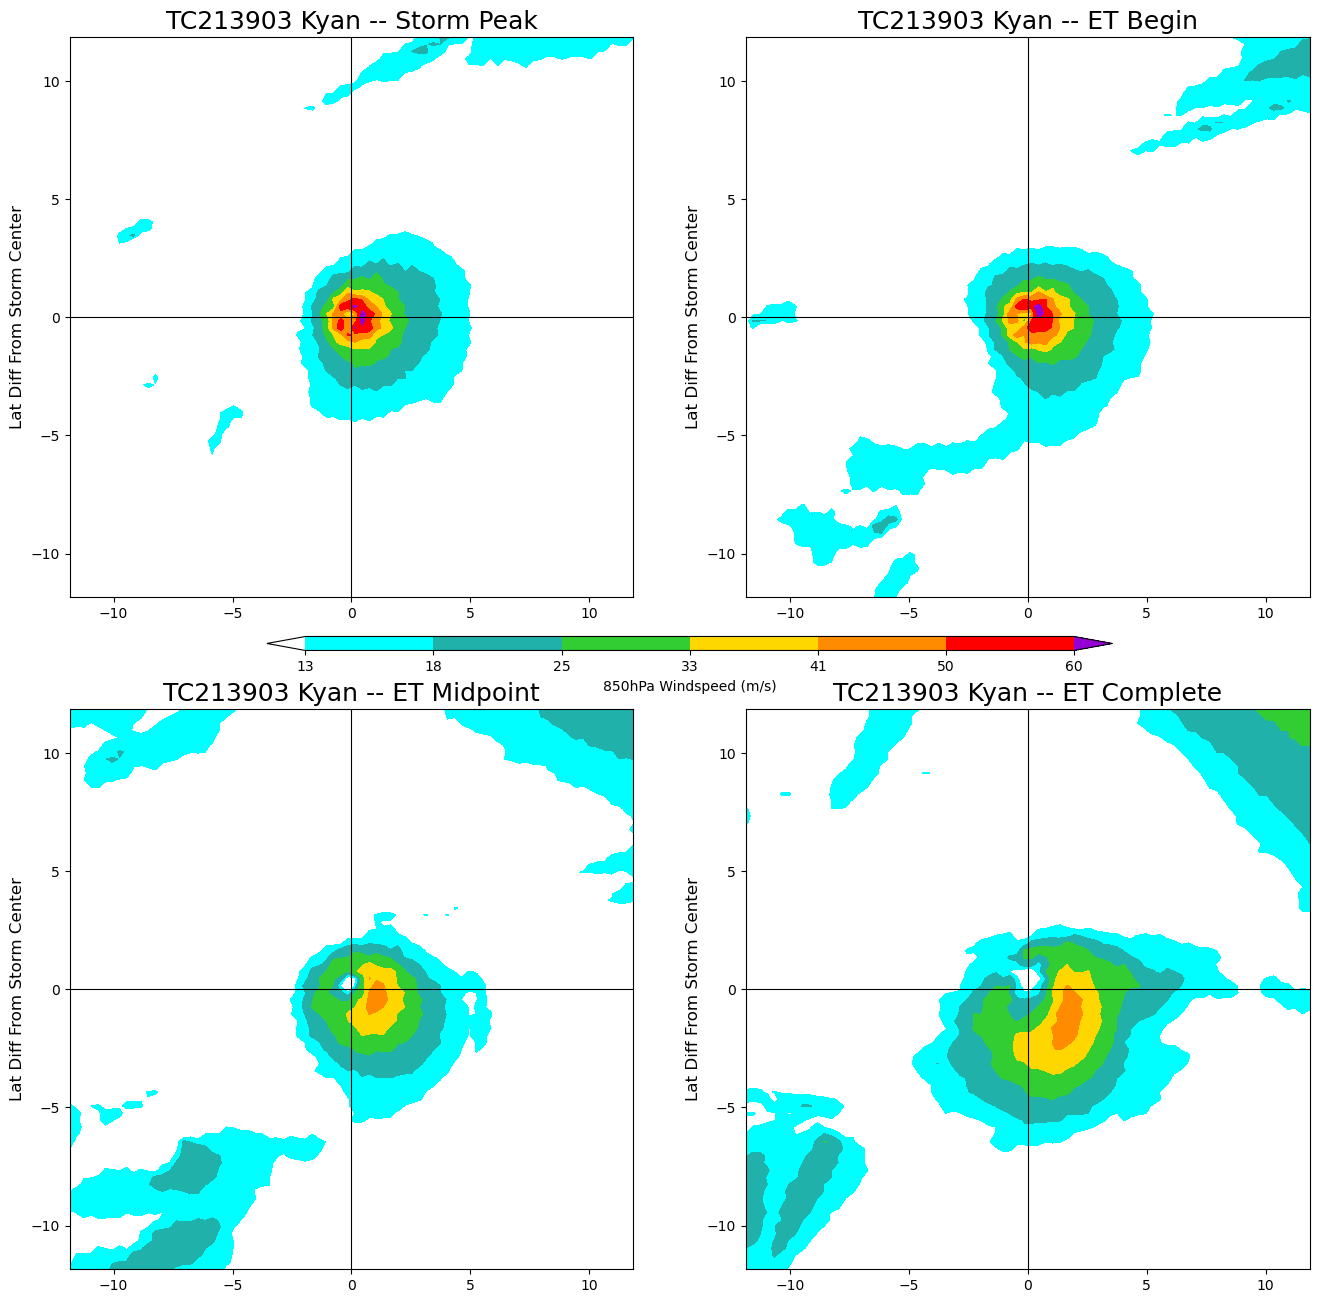

In [92]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

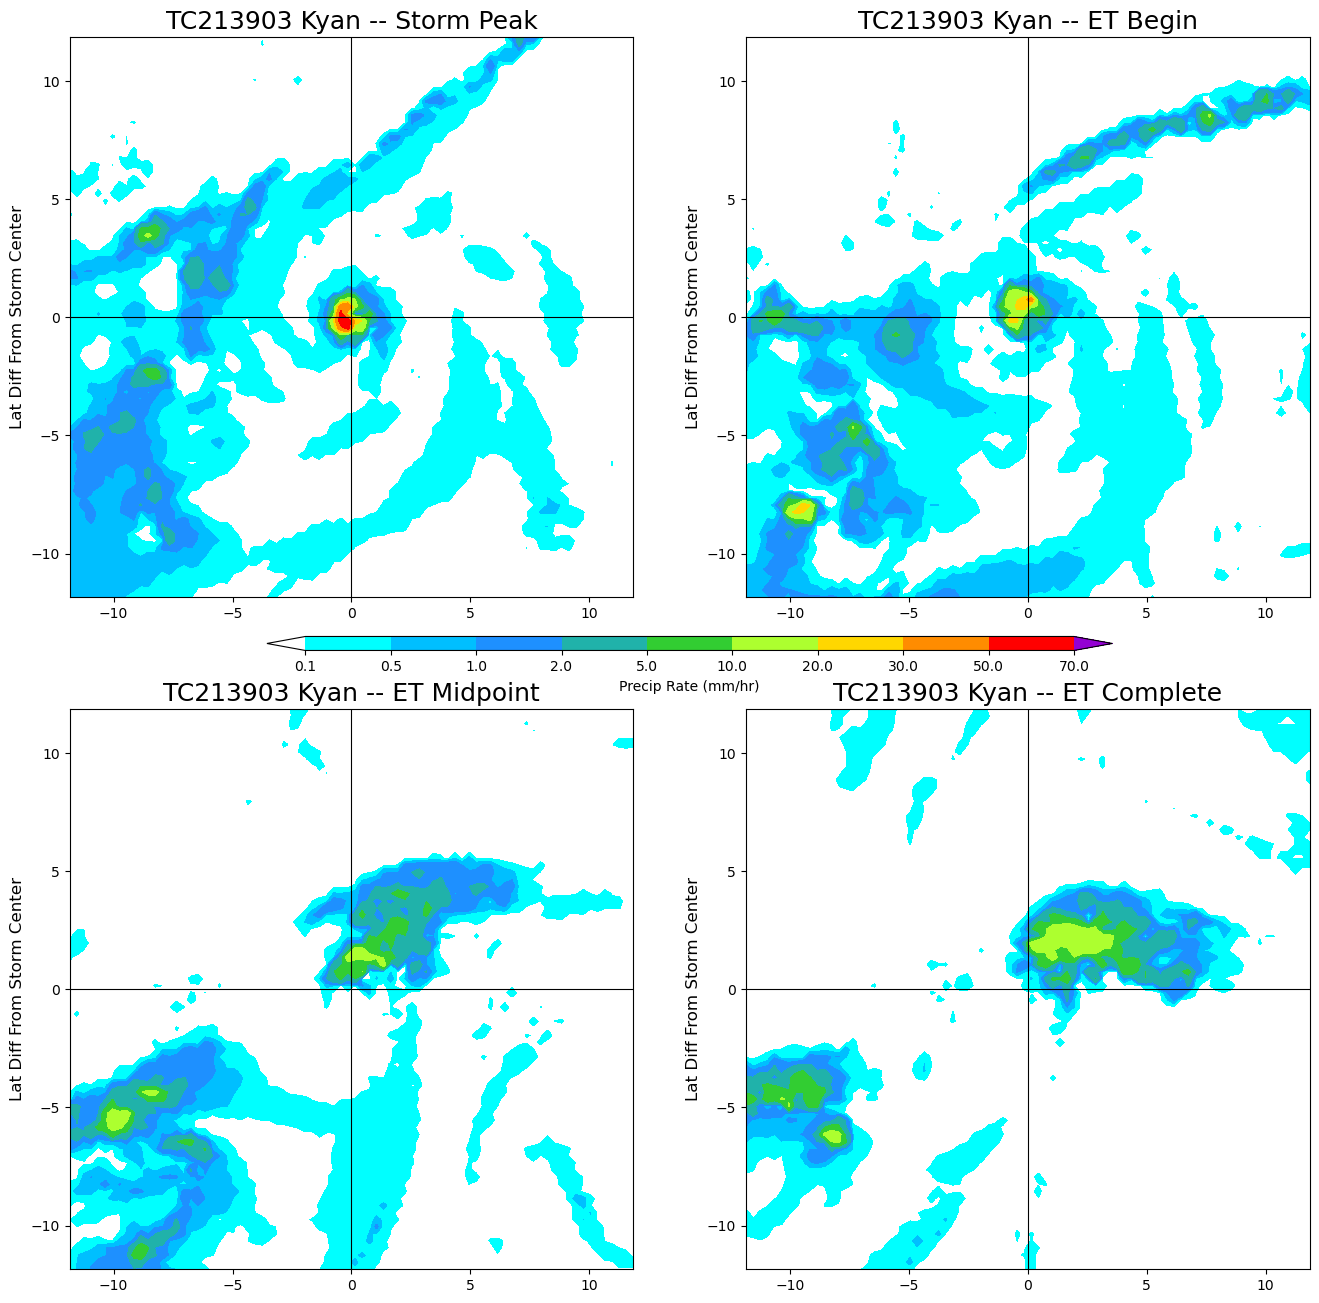

In [93]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

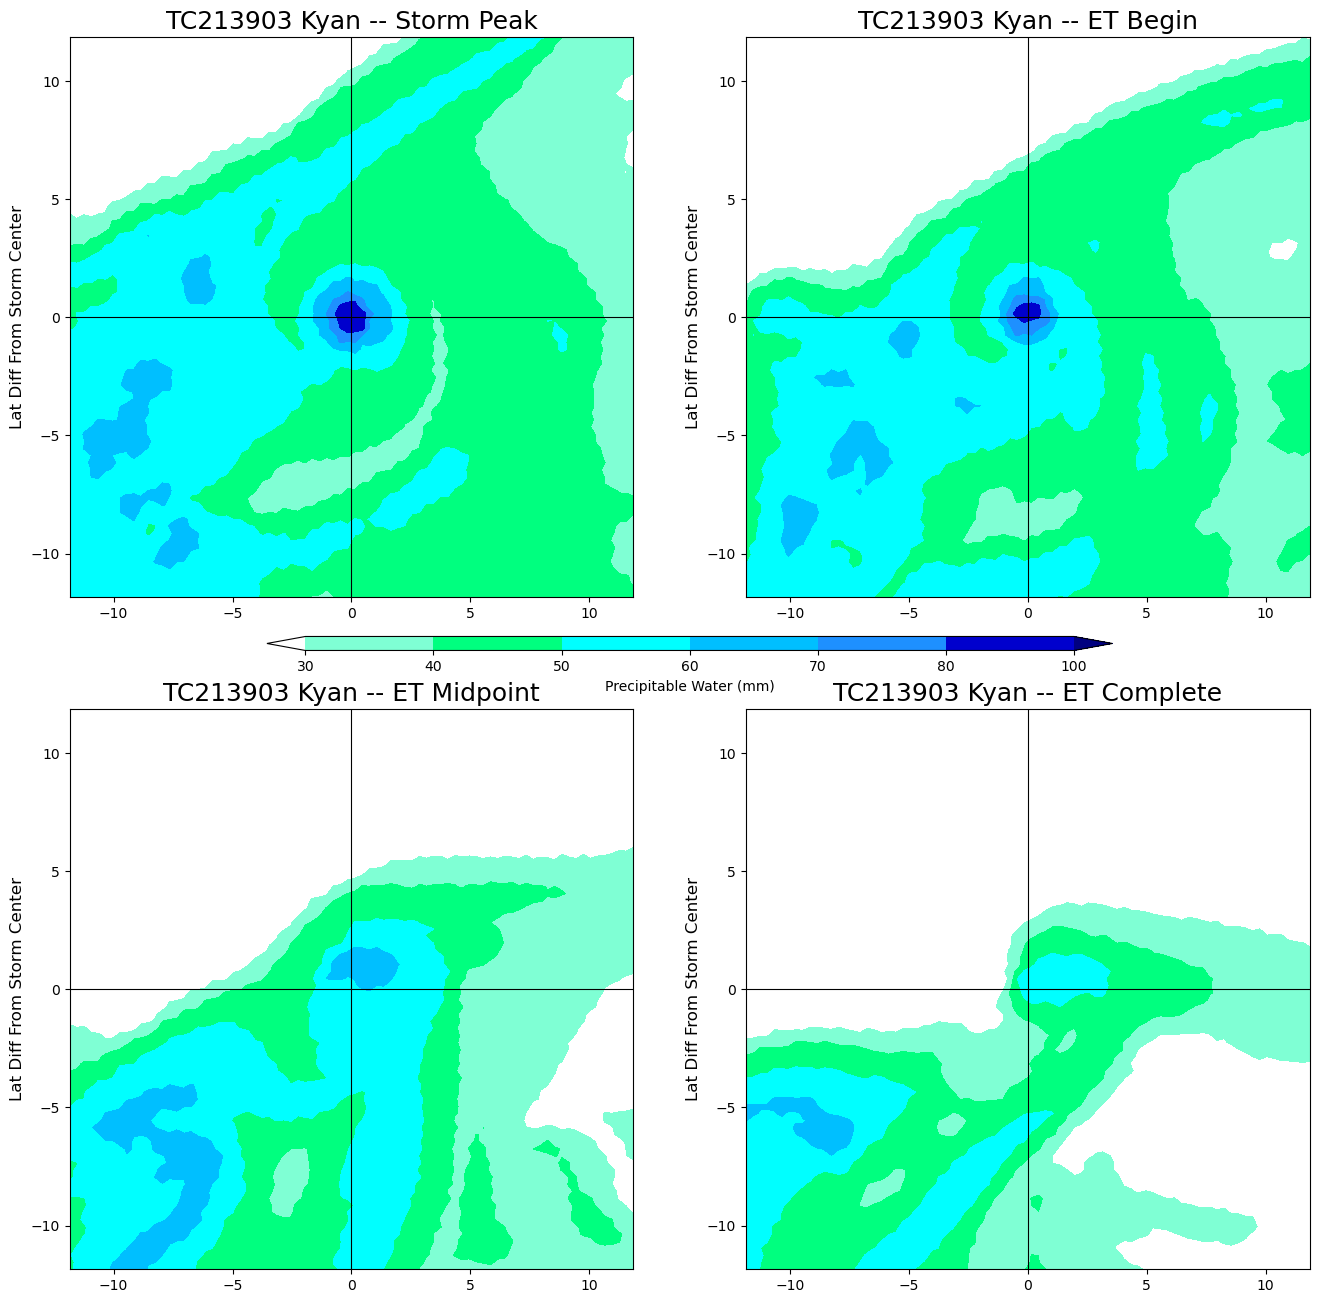

In [94]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)

In [95]:
# Find Wind Field Composite Data
Code = "TC216105"
Storm_Name = "Rachel"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_B_Compo_nc
Time_Indexes = [6819,6837,6841,6845]
Time_Labels = ["Initial Storm Peak", "Storm Peak/ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [96]:
#DF_Storm_Compo_Wind_Field[50:]

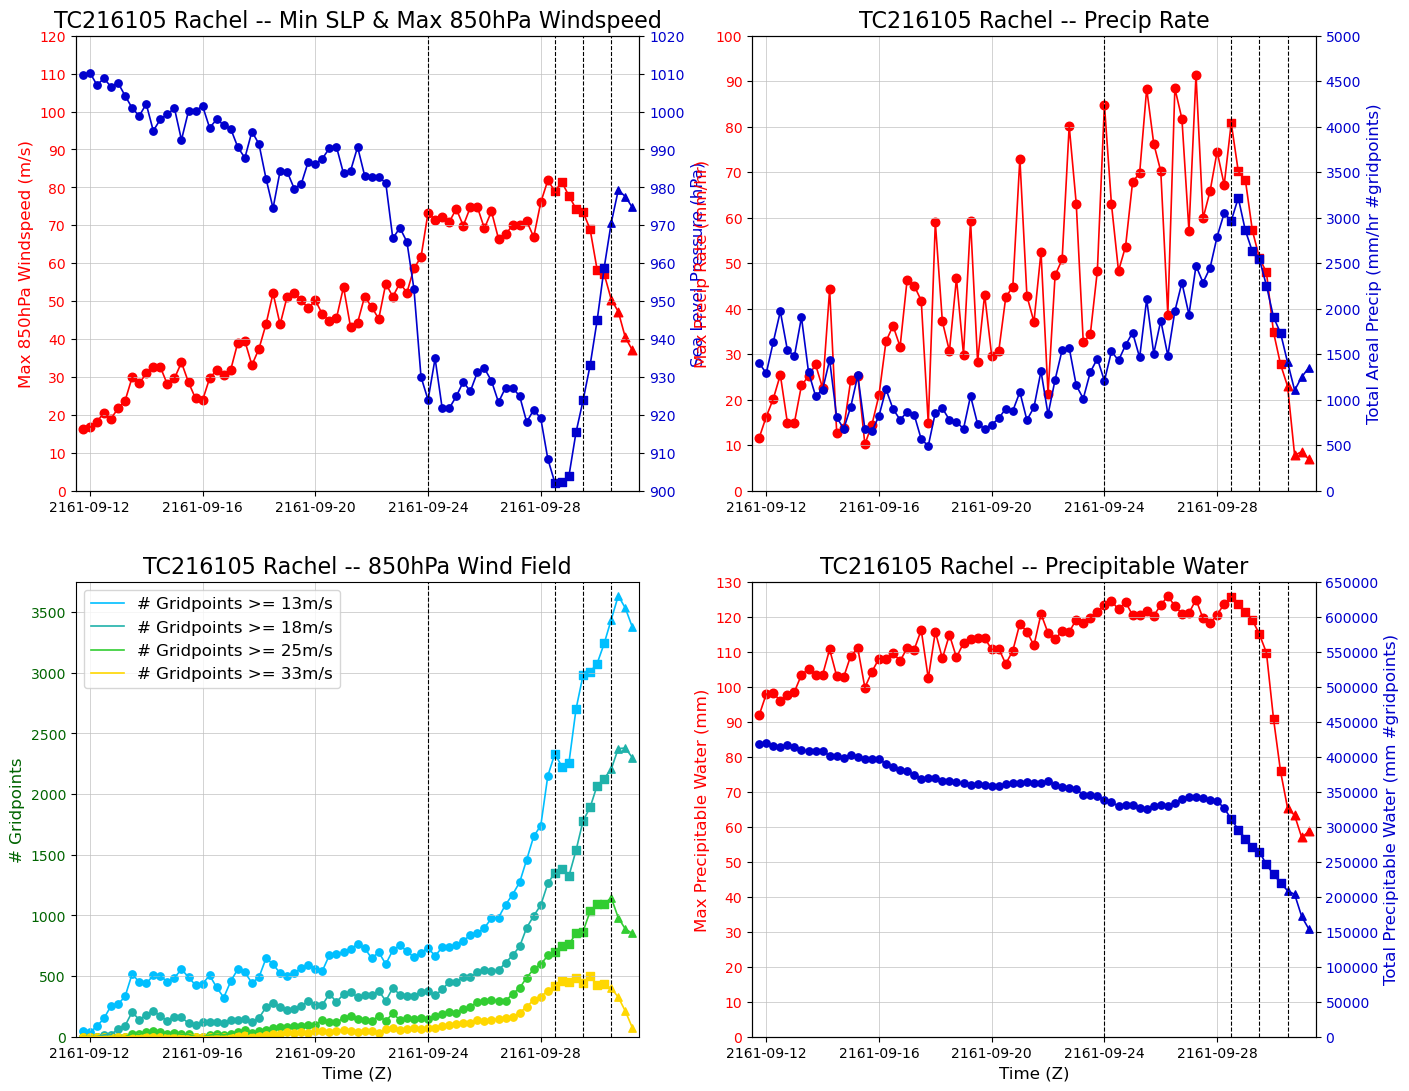

In [97]:
Fig = pyplot.figure(figsize=(16,13))
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Rate Information
Precip_Rate_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precipitable Water Information
Precip_Water_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Plot Precip Field Information
#Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes)
# Savefig
Figname = str(Code + '_' + Storm_Name + '_Wind_Precip_Fields.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

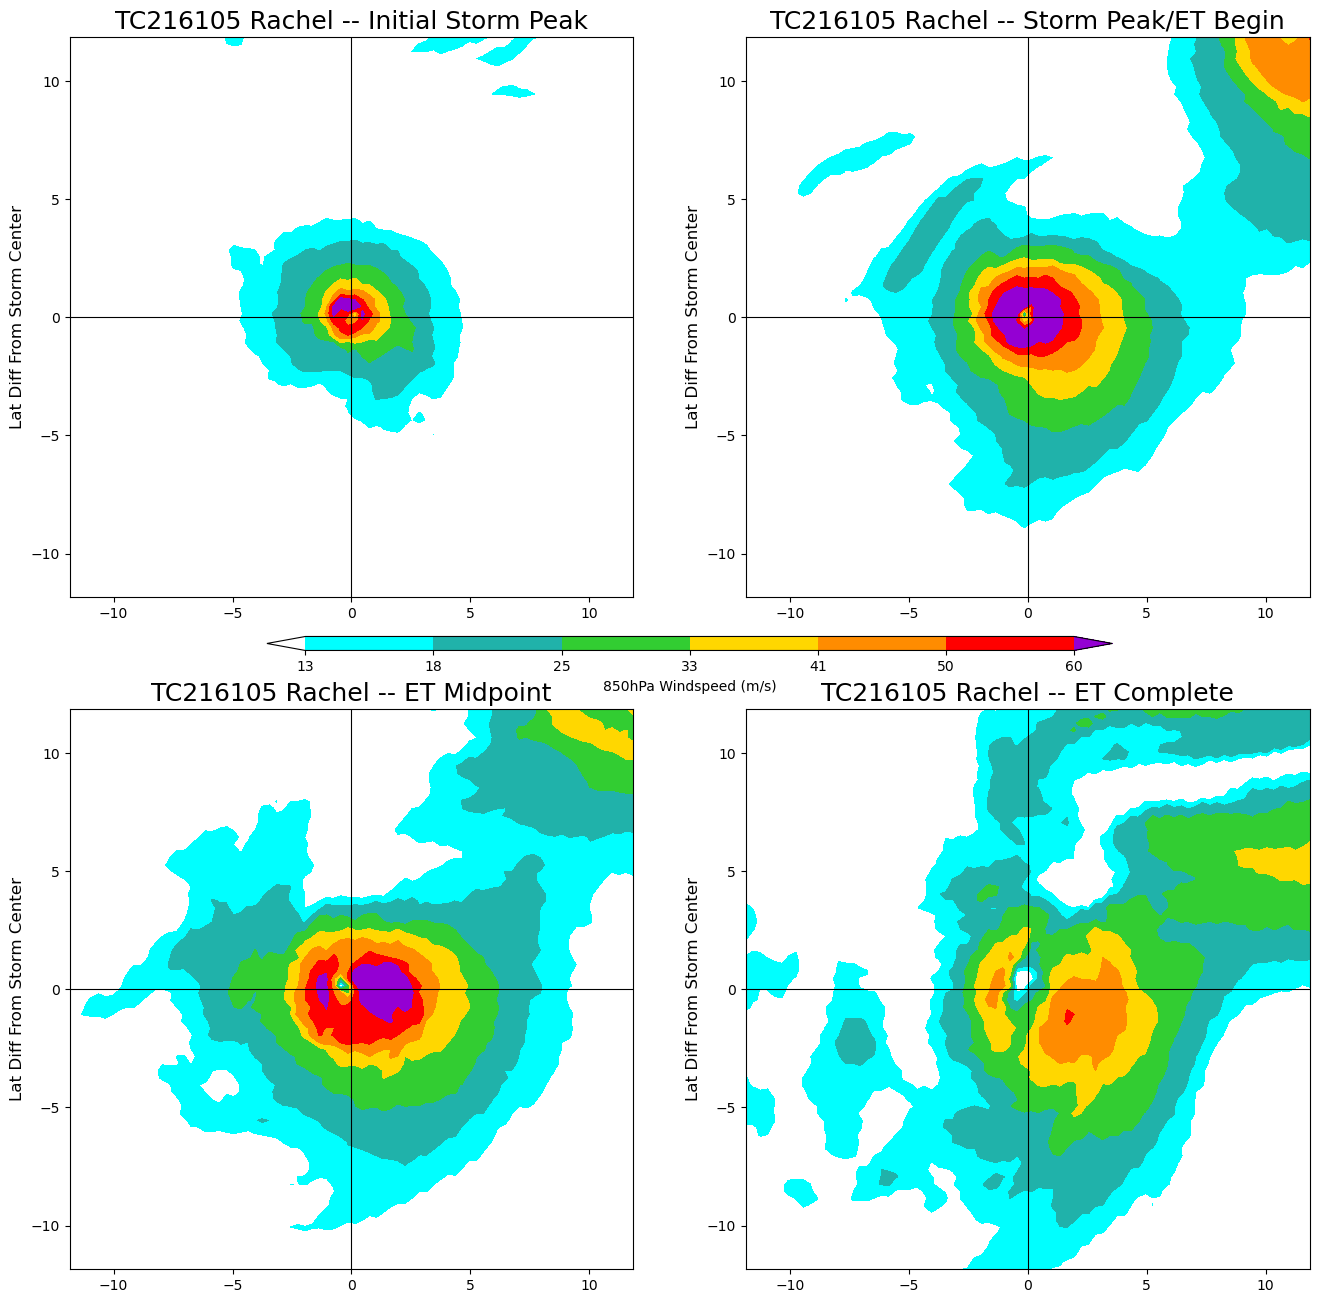

In [98]:
# Plot 850hPa Wind Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"850hPa Windspeed", "m/s", Windspeed_Bounds, Windspeed_Colours, True)

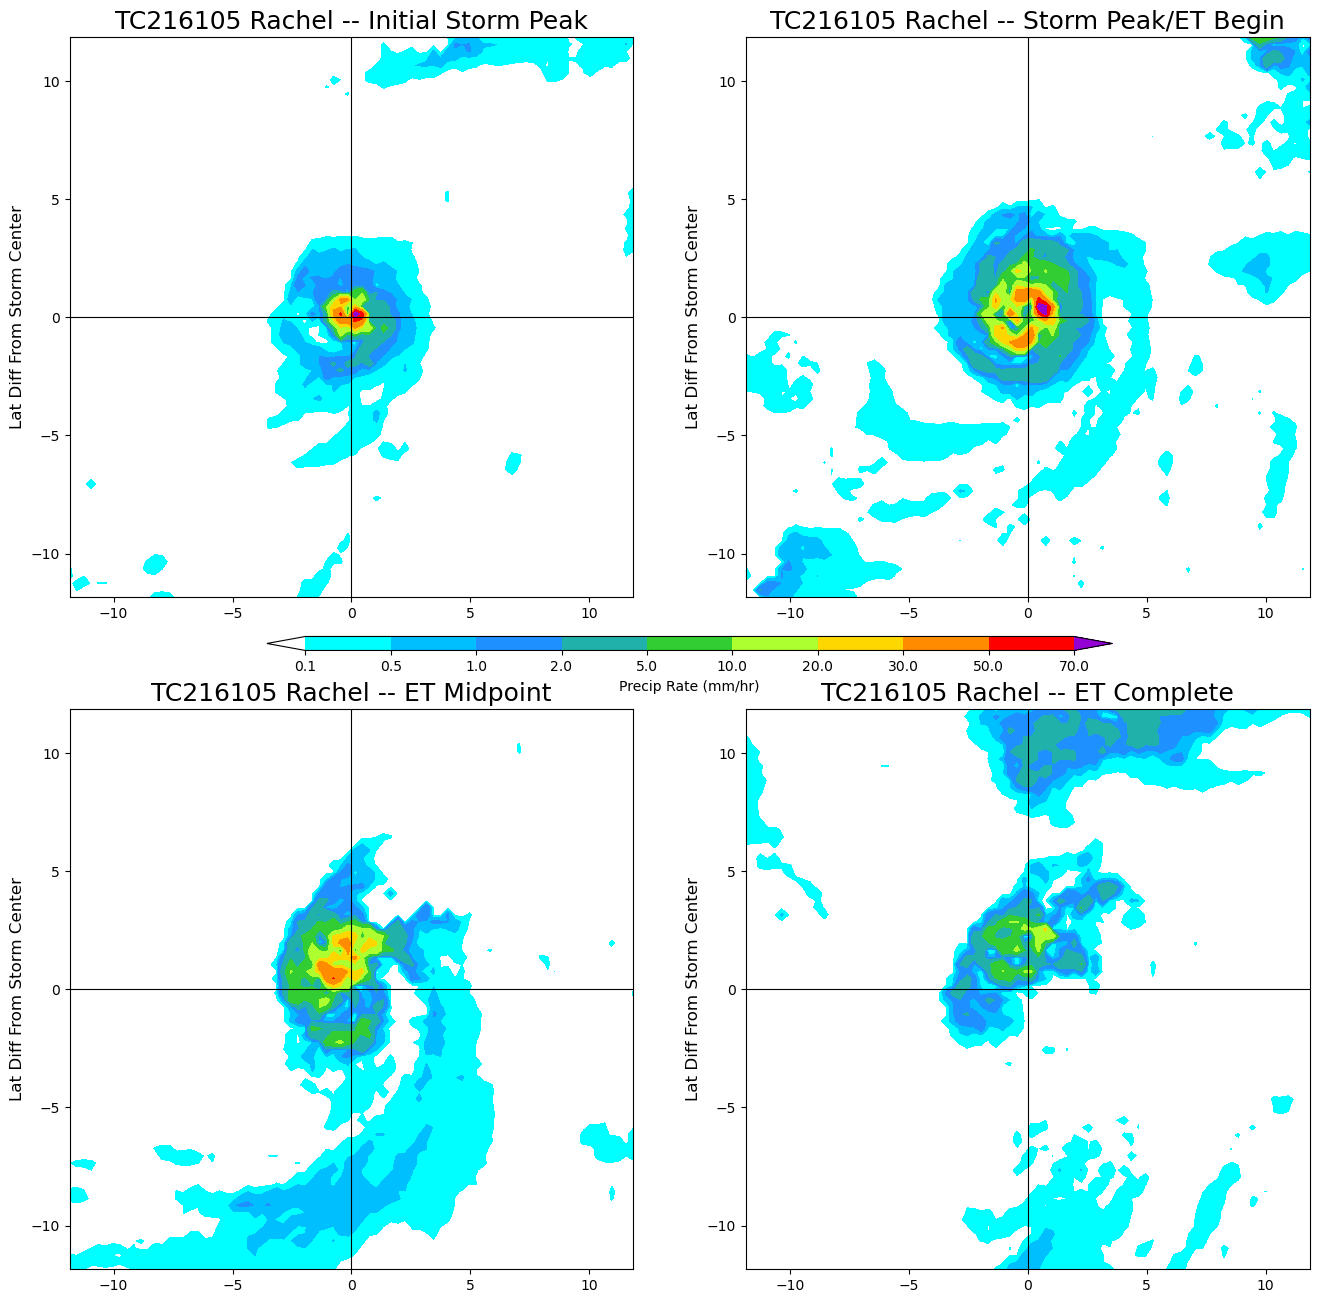

In [99]:
# Plot Precip Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precip Rate", "mm/hr", Precip_Rate_Bounds, Precip_Rate_Colours, True)

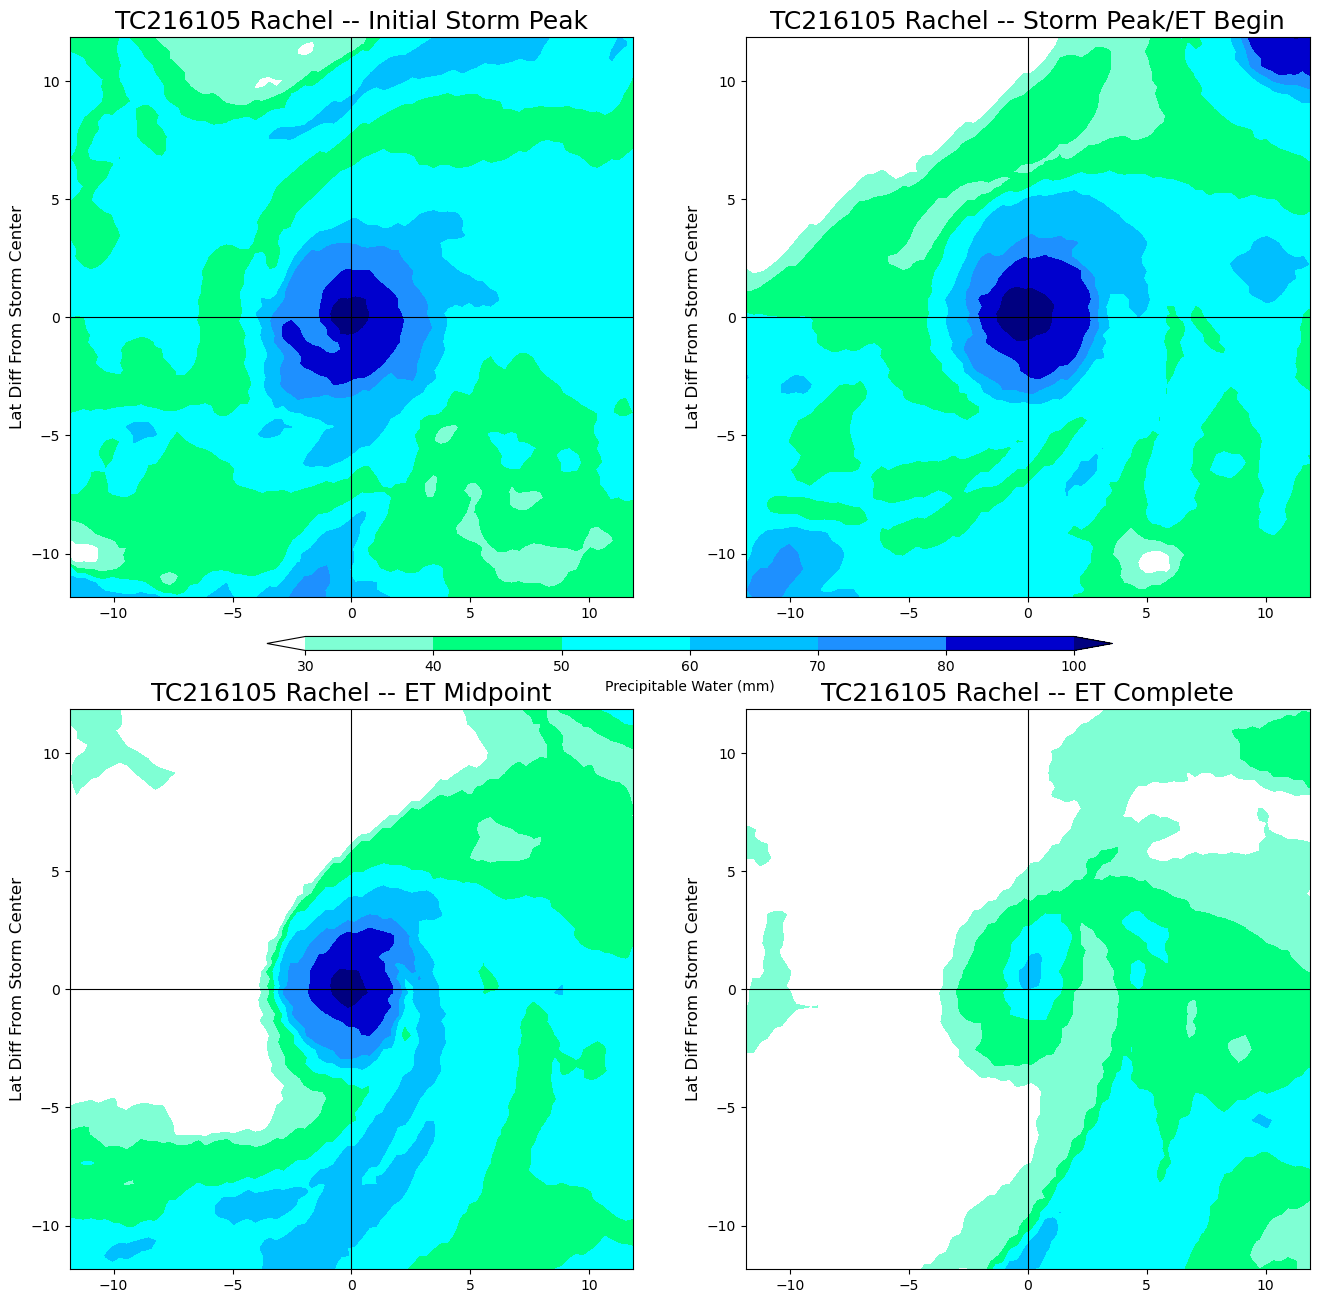

In [100]:
# Plot Precipitable Water Field Snapshots
Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
"Precipitable Water", "mm", Precip_Water_Bounds, Precip_Water_Colours, True)